# Census Annual Business Survey (ABS) APIs Investigation, Analysis, and Visualization

***
***

## Data Investegation (Transform, Merge, Clean)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
import plotly.express as px
import pandas as pd
import requests
import json
import numpy as np
import math
from Configuration.config_ import apikey

### Census State Populations
***

**STEP #1 (Census State Populations)**<br>
In order to later standardize the the aggregated census value data column 'FIRMPDEMP', we imported a seconday census dataset showing National, Regional, and State total populations to hopefully reduce population size bias. The data came from <href>https://www.census.gov/newsroom/press-kits/2019/national-state-estimates.html</href> which had total populations from a range of years with excess data meaning it required cleaning. To do so we first read in the data on the excel 'nst-est2019-01.xlsx' table with the pandas pd.read_excel() function, skipping 3 rows to remove excess title information. We then renamed to two needed columns in the data so that 'Unamed 0' became 'State' and 2018 beecame 'Population' (changing the int data type to a string for ease of refrence). After this we removed all other columns using the pandas pd.drop() function. Then with further data exploration we learned we only needed state data, so we removed any unneeded row once again using the pd.drop() function. After this we used lambda functions to map all the 'State' column data to be a string and all the 'Population' column data to be a float. In the lambda function for the 'Location column we also removed the first character from each string which was a period making it so we couldn't accuratly refrence the state location. From there we reset the index, moving a secondary manipulated index column into the DataFrame, then removed it with pd.drop() as it was an excess column only refrencing the unmanipluated table previously imported. This leaves me with census_national_populations which contains state names and total population in 2018.

In [4]:
census_national_populations = pd.read_excel("./Files/nst-est2019-01.xlsx", skiprows=3)
census_national_populations = census_national_populations.rename(columns={"Unnamed: 0": "State", 2018:"Population"})
census_national_populations = census_national_populations.drop(["Census", "Estimates Base",2010,2011,2012,2013,2014,2015,2016,2017,2019],axis=1)
census_national_populations = census_national_populations.drop([0,1,2,3,4,56,57,58,59,60,61,62])
census_national_populations['State'] = census_national_populations['State'].apply(lambda x : str(x[1:]))
census_national_populations["Population"] = census_national_populations["Population"].apply(lambda x : float(x))
census_national_populations.reset_index(inplace=True)
census_national_populations = census_national_populations.drop("index",axis=1)
census_national_populations.head()

,State,Population
0,Alabama,4887681.0
1,Alaska,735139.0
2,Arizona,7158024.0
3,Arkansas,3009733.0
4,California,39461588.0


### Company Summary
***

**STEP #1 (Company Summary)** <br>
WE requested both U.S. and State data from the 2019 Annual Business Survey (ABS) Company Summary. We used request.get() to pull the data from the Census website then used requests fdeature .json() in order to transform the data into a list of lists split by newlines at the end of each row. We had to use my cenus key to access all data all the data from the url rather than just the first 500 rows which is the default for requests from the ABS Census API. We only imported columns variables; NAME, SEX,SEX_LABEL, RACE_GROUP, RACE_GROUP_LABEL, FIRMPDEMP. This was to limit unneeded data calls and grab needed information for later visualizations. The imported U.S. data is named reponse_company_summary_Nation and the state data is named reponse_company_summary_State.

In [5]:
reponse_company_summary_Nation = requests.get(f"https://api.census.gov/data/2018/abscs?get=NAME,SEX,SEX_LABEL,RACE_GROUP,RACE_GROUP_LABEL,FIRMPDEMP&for=us:*&key={apikey}").json()
reponse_company_summary_State = requests.get(f"https://api.census.gov/data/2018/abscs?get=NAME,SEX,SEX_LABEL,RACE_GROUP,RACE_GROUP_LABEL,FIRMPDEMP&for=state:*&key={apikey}").json()

**STEP #2 (Company Summary)** <br>
We transformed both of my datasets from list of lists to a pandas DataFrame useing pd.DataFrame() where the first list of each dataset was set to 'columns' meaning it would be the header of the table and then set the rest of the dataset to 'data' representing each list as a rowe in the DataFrame. Here you see reponse_company_summary_Nation transofrms to df_company_summary_Nation, and reponse_company_summary_State transforms to df_company_summary_State.

In [6]:
df_company_summary_Nation = pd.DataFrame(data=reponse_company_summary_Nation[1:], columns=reponse_company_summary_Nation[0])
df_company_summary_State = pd.DataFrame(data=reponse_company_summary_State[1:], columns=reponse_company_summary_State[0])

**STEP #3 (Company Summary)** <br>
For this step we transfiorm merge and clean the df_company_summary_State DataFrame. First I make a copy of the DataFrame for ease of use. Then we rename the column 'NAME' in df_company_summary_State to 'State' in order to merge with census population data where we do an inner merge on the column 'State' with df_company_summary_State and census_national_populations to create a more informative df_company_summary_State DataFrame. From here we drop the 'state' column as it is unessacary for later visualizations. I then rename the column 'Population' to 'Total_Population' so it's easier to understand the meaning of the column. After this I set the columns 'FIRMPDEMP' and 'Total_Population' to integers to allow later amthimatical transformations. 

In [7]:
df_company_summary_State = df_company_summary_State.copy()
df_company_summary_State = df_company_summary_State.rename(columns={"NAME":"State"})
df_company_summary_State = df_company_summary_State.merge(census_national_populations, how= 'inner', on="State")
df_company_summary_State = df_company_summary_State.drop(["state"], axis = 1)
df_company_summary_State = df_company_summary_State.rename(columns={"Population":"Total_Population"})
df_company_summary_State["FIRMPDEMP"] = df_company_summary_State["FIRMPDEMP"].astype(int)
df_company_summary_State["Total_Population"] = df_company_summary_State["Total_Population"].astype(int)

**STEP #4 (Company Summary)**<br>
For this step we do further transforming and cleaning of the DataFrame by first copying df_company_summary_State and setting it to df_company_summary_State_bussniess_per_population to better refrence the meaning of the dataset. We then create a new column called 'Bus_Num_by_Pop' to refrence a column finding the number of busniesses based on the total population of the state which is calculated by dividing the 'FIRMPDEMP' column by the 'Total_Population' column that is then mutliplied by 100 to create a proportional percentage column. From there we remove unneeded columns; 'RACE_GROUP', 'Total_Population', 'SEX', 'FIRMPDEMP'. After this we cleaned the remaining columns by taking out rows with labels that aggregagte rows together such as 'Total' and 'Equally male/female' for the 'SEX_LABEL' column and 'Total', 'Minority', 'Nonminority', and 'Equally minority/nonminority' for the 'RACE_GROUP_LABEL' column. This leaves df_company_summary_State_bussniess_per_population with only 4 columns.

In [8]:
df_company_summary_State_bussniess_per_population = df_company_summary_State.copy()
df_company_summary_State_bussniess_per_population["Bus_Num_by_Pop"] = (df_company_summary_State_bussniess_per_population["FIRMPDEMP"] / df_company_summary_State_bussniess_per_population["Total_Population"]) * 100
df_company_summary_State_bussniess_per_population = df_company_summary_State_bussniess_per_population.drop(["RACE_GROUP", "Total_Population", "SEX", "FIRMPDEMP"], axis=1)
df_company_summary_State_bussniess_per_population = df_company_summary_State_bussniess_per_population[df_company_summary_State_bussniess_per_population["SEX_LABEL"] != "Total"]
df_company_summary_State_bussniess_per_population = df_company_summary_State_bussniess_per_population[df_company_summary_State_bussniess_per_population["SEX_LABEL"] != "Equally male/female"]
df_company_summary_State_bussniess_per_population = df_company_summary_State_bussniess_per_population[df_company_summary_State_bussniess_per_population["RACE_GROUP_LABEL"] != "Total"]
df_company_summary_State_bussniess_per_population = df_company_summary_State_bussniess_per_population[df_company_summary_State_bussniess_per_population["RACE_GROUP_LABEL"] != "Minority"]
df_company_summary_State_bussniess_per_population = df_company_summary_State_bussniess_per_population[df_company_summary_State_bussniess_per_population["RACE_GROUP_LABEL"] != "Nonminority"]
df_company_summary_State_bussniess_per_population = df_company_summary_State_bussniess_per_population[df_company_summary_State_bussniess_per_population["RACE_GROUP_LABEL"] != "Equally minority/nonminority"]

**STEP #5 (Company Summary)**<br>
For this final step using the df_company_summary_State_bussniess_per_population DataFrame we first use a complex pandas groupby() function to group by categorical columns 'State', 'SEX_LABEL', and 'RACE_GROUP_LABEL' then aggregate a sum of the 'Bus_Num_by_Pop' by grouping. To follow this we sort the DataFrame alphabeticly by categorical columns 'State', 'SEX_LABEL', and 'RACE_GROUP_LABEL'. This gives me a sorted aggragated DataFrame which can be refrenced by state, sex, and race showing the numericaly standarized column 'Bus_Num_by_Pop'.

In [9]:
df_company_summary_State_bussniess_per_population.groupby(["State", "SEX_LABEL", "RACE_GROUP_LABEL" ] ,as_index=False)["Bus_Num_by_Pop"].sum()
df_company_summary_State_bussniess_per_population = df_company_summary_State_bussniess_per_population.sort_values(by=["State","RACE_GROUP_LABEL", "SEX_LABEL"], ascending=True)
df_company_summary_State_bussniess_per_population.head()

,State,SEX_LABEL,RACE_GROUP_LABEL,Bus_Num_by_Pop
950,Alabama,Female,American Indian and Alaska Native,0.000000
951,Alabama,Male,American Indian and Alaska Native,0.004910
954,Alabama,Female,Asian,0.030055
955,Alabama,Male,Asian,0.063752
942,Alabama,Female,Black or African American,0.011007


**STEP #6 (Company Summary)** <br>
In this step we repeat many of the previous tranformation and cleaning steps from the state DataFrame with some slight differences for the U.S. natioal DataFrame df_company_summary_Nation. First we renamed copied the DataFrame and renamed it df_company_summary_Overall to show the data would be changed. Then we renamed the 'NAME' column 'Location' to match the previously made state DataFrame. From there we remvoed unneeded columns in the DataFrame such as 'Total' and 'Equally male/female' for the 'SEX_LABEL' column and 'Total', 'Minority', 'Nonminority', and 'Equally minority/nonminority' for the 'RACE_GROUP_LABEL' column. Then we grouped the data by the categorical columns 'Location', 'SEX_LABEL', and 'RACE_GROUP_LABEL' and aggragated the sum of the 'FIRMPDEMP'. From there we sorted the values by the categorical columns 'Location', 'SEX_LABEL', and 'RACE_GROUP_LABEL' in alphabetical order for ease of refrence when viewing in tabular form. Then we reset the indexa nd dropped the unneeded index column as it refrenced the original table rather than the new cleaned table df_company_summary_Overall. This leave the df_company_summary_Overall DataFrame with 4 columns for refrence. 

In [10]:
df_company_summary_Overall = df_company_summary_Nation.copy()
df_company_summary_Overall = df_company_summary_Overall.rename(columns={"NAME":"Location"})
df_company_summary_Overall = df_company_summary_Overall.drop(["RACE_GROUP", "SEX", "us"], axis=1)
df_company_summary_Overall = df_company_summary_Overall[df_company_summary_Overall["SEX_LABEL"] != "Total"]
df_company_summary_Overall = df_company_summary_Overall[df_company_summary_Overall["SEX_LABEL"] != "Equally male/female"]
df_company_summary_Overall = df_company_summary_Overall[df_company_summary_Overall["RACE_GROUP_LABEL"] != "Total"]
df_company_summary_Overall = df_company_summary_Overall[df_company_summary_Overall["RACE_GROUP_LABEL"] != "Minority"]
df_company_summary_Overall = df_company_summary_Overall[df_company_summary_Overall["RACE_GROUP_LABEL"] != "Nonminority"]
df_company_summary_Overall = df_company_summary_Overall[df_company_summary_Overall["RACE_GROUP_LABEL"] != "Equally minority/nonminority"]
df_company_summary_Overall.groupby(["Location", "SEX_LABEL", "RACE_GROUP_LABEL" ] ,as_index=False)["FIRMPDEMP"].sum()
df_company_summary_Overall = df_company_summary_Overall.sort_values(by=["Location","RACE_GROUP_LABEL", "SEX_LABEL"], ascending=True)
df_company_summary_Overall.reset_index(level = 0, inplace= True)
df_company_summary_Overall = df_company_summary_Overall.drop("index", axis=1)
df_company_summary_Overall.head(10)

,Location,SEX_LABEL,RACE_GROUP_LABEL,FIRMPDEMP
0,United States,Female,American Indian and Alaska Native,8985
1,United States,Male,American Indian and Alaska Native,14559
2,United States,Female,Asian,154984
3,United States,Male,Asian,336622
4,United States,Female,Black or African American,43163
5,United States,Male,Black or African American,69624
6,United States,Female,Native Hawaiian and Other Pacific Islander,0
7,United States,Male,Native Hawaiian and Other Pacific Islander,4468
8,United States,Female,White,945514
9,United States,Male,White,3087049


### Characteristics of Businesses
***

**STEP #1 (Characteristics of Businesses)** <br>
Consuming the API

In [11]:
response = requests.get(f'http://api.census.gov/data/2018/abscb?get=GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,SEX,SEX_LABEL,ETH_GROUP,ETH_GROUP_LABEL,RACE_GROUP,RACE_GROUP_LABEL,FIRMPDEMP,EMP,PAYANN&for=us:*&key={apikey}')
response_dict = response.json()
business = pd.DataFrame.from_dict(response_dict)
business.columns = business.iloc[0]
business = business.drop(business.index[0])

**STEP #2 (Characteristics of Businesses)** <br>
Getting rid of unnecessary columns

In [12]:
drop_columns = ['GEO_ID','NAME','NAICS2017','SEX','ETH_GROUP','RACE_GROUP','us']
business = business.drop(drop_columns, axis=1)

**STEP #3 (Characteristics of Businesses)** <br>
Making more meaningful column names

In [13]:
business.rename(columns={'NAICS2017_LABEL':'industry',
                        'SEX_LABEL':'sex',
                        'ETH_GROUP_LABEL':'ethnic_group',
                        'RACE_GROUP_LABEL':'race',
                        'FIRMPDEMP':'employer_firms',
                        'EMP':'employees',
                        'PAYANN':'payroll'}, inplace=True)

**STEP #4 (Characteristics of Businesses)**<br>
Making numeric columns into floats

In [14]:
columns_float = ['employer_firms', 'employees', 'payroll']

for column in columns_float:
    business[column]=business[column].astype('float')

**STEP #5 (Characteristics of Businesses)**<br>
Make sex table to work with

In [15]:
business_gender = business.copy()
business_gender = business_gender[['industry','sex','employer_firms','employees','payroll']]
business_gender = business_gender[(business_gender['sex']=='Female')|(business_gender['sex']=='Male')]
business_gender=business_gender.groupby(['industry','sex'],as_index=False).sum()
business_gender.head()

,industry,sex,employer_firms,employees,payroll
0,Accommodation and food services,Female,323922.0,4564097.0,83356782.0
1,Accommodation and food services,Male,919556.0,21554932.0,410812299.0
2,Administrative and support and waste managemen...,Female,212394.0,3829456.0,130116237.0
3,Administrative and support and waste managemen...,Male,646773.0,15294918.0,548775162.0
4,"Agriculture, forestry, fishing and hunting",Female,9160.0,74067.0,1618349.0


**STEP #6 (Characteristics of Businesses)**<br>
Make ethnicity table to work with

In [16]:
business_ethnicity = business.copy()
business_ethnicity = business_ethnicity[['industry','ethnic_group','employer_firms','employees','payroll']]
business_ethnicity = business_ethnicity[(business_ethnicity['ethnic_group']!='Total')&(business_ethnicity['ethnic_group']!='Classifiable')&(business_ethnicity['ethnic_group']!='Unclassifiable')]
business_ethnicity=business_ethnicity.groupby(['industry','ethnic_group'],as_index=False).sum()
business_ethnicity.head()

,industry,ethnic_group,employer_firms,employees,payroll
0,Accommodation and food services,Equally Hispanic/non-Hispanic,11323.0,249530.0,4601243.0
1,Accommodation and food services,Hispanic,90256.0,1420190.0,27015967.0
2,Accommodation and food services,Non-Hispanic,945294.0,19407667.0,364188563.0
3,Administrative and support and waste managemen...,Equally Hispanic/non-Hispanic,8433.0,85386.0,2631275.0
4,Administrative and support and waste managemen...,Hispanic,63285.0,1030424.0,31018274.0


**STEP #7 (Characteristics of Businesses)**<br>
Make race table to work with

In [17]:
business_race = business.copy()
business_race = business_race[['industry','race','employer_firms','employees','payroll']]
business_race = business_race[(business_race['race']!='Total')&(business_race['race']!='Classifiable')&(business_race['race']!='Unclassifiable')]
business_race=business_race.groupby(['industry','race'],as_index=False).sum()
business_race.head()


,industry,race,employer_firms,employees,payroll
0,Accommodation and food services,American Indian and Alaska Native,1786.0,24869.0,455051.0
1,Accommodation and food services,Asian,141746.0,1784264.0,33891188.0
2,Accommodation and food services,Black or African American,7714.0,199284.0,3161908.0
3,Accommodation and food services,Equally minority/nonminority,18657.0,389045.0,7236075.0
4,Accommodation and food services,Minority,389641.0,5418713.0,101798745.0


### Characteristics of Bussniess Owners
***

**STEP #1 (Characteristics of Business Owners)**<br>
Create a national link that calls the desired data with a personal api key. Create a state link that calls the desired data with a personal api key. I planned analyze demographic information on the national level, and business ownership rates on the state level so I called race and sex in the national link, and ownerhip numbers in the state link


In [18]:
nationalLink = f'https://api.census.gov/data/2018/abscbo?get=NAME,OWNER_SEX,OWNER_SEX_LABEL,OWNER_RACE,OWNER_RACE_LABEL,OWNPDEMP&for=us:*&key={apikey}'
stateLink = f'https://api.census.gov/data/2018/abscbo?get=NAME,OWNPDEMP&for=state:*&key={apikey}'

**STEP #2 (Characteristics of Business Owners)**<br>
Call the data from the excel file containing populations by state from the following link: https://www.census.gov/newsroom/press-kits/2019/national-state-estimates.html 
*This will be used later to get data adjusted to each states population*. Skip the first three rows since they contain information about the dataset not the data itself. The first column of location names is unamed, so give it a temporary name. This Business data comes from 2018, so drop all other columns and years other than the location name column, and the year 2018. The first few rows contain information be region and on the national level, and the last few contain citations, so remove all rows but the 50 states and DC (remove Puerto Rico as well). Convert the string data in the 2018 column to a numeric value, in this case a float. Restart the indices. Rename the 2018 column to population, and the unamed column to match the statename column called from the business data

In [19]:
parameters = {}
r = requests.get(nationalLink, parameters)
colNames = ["State","sex", "sexLabel", "race", "raceLabel","numOwners","us"]
businessOwner = pd.DataFrame(columns=colNames, data=r.json()[1:])
businessOwner = businessOwner[businessOwner.sex.isin(['001']) == False]
businessOwner = businessOwner[businessOwner.race.isin(['00']) == False]
businessOwner = businessOwner.drop(['State','sex', 'race','us'], axis=1)
businessOwner['numOwners'] = businessOwner['numOwners'].astype(int)
businessOwner.head()

,sexLabel,raceLabel,numOwners
0,Female,Black or African American,248
1,Male,Black or African American,977
7,Female,White,32051
8,Male,White,108193
10,Female,American Indian and Alaska Native,127


**STEP #3 (Characteristics of Business Owners)**<br>
Request the national data from the census website and fill into an empty list. Create columns and make a dataframe out of that list. Remove rows that contain aggrageted total data rather than data based on individual races or sexes. Drop uncessary columns such as location as we know we are looking at the whole U.S, the us number which is all 1, and the numberedIDs of each race and sex as we will only look at the strings. Convert numOnwers to an int value.

In [20]:
parameters = {}
r = requests.get(stateLink, parameters)
colNames = ["State","numOwners","state"]
businessOwnerState = pd.DataFrame(columns=colNames, data=r.json()[1:])
businessOwnerState = businessOwnerState.drop(['state'], axis=1)
businessOwnerState['numOwners'] = businessOwnerState['numOwners'].astype(int)

**STEP #4 (Characteristics of Business Owners)**<br>
Request the state data from the census website and fill into an empty list. Create columns and make a dataframe out of that list. Drop the column containing state numbers. Convert numOnwers to an int value.

In [21]:
census_national_populations = census_national_populations.copy()
census_national_populations_Owners = census_national_populations
businessOwnerState = businessOwnerState.merge(census_national_populations_Owners, how='inner', on='State')
businessOwnerState["ownerPer100People"] = (businessOwnerState["numOwners"] / businessOwnerState["Population"]) * 100

**STEP #5 (Characteristics of Business Owners)**<br>
Merge the population by state excel file dataframe onto the recently created business owners by state dataframe by their shared location column. Create a new column that looks at business owners per 100 people by dividing number of owners by population and multiplying by 100.

In [32]:
stateToCode = pd.read_csv('./Files/name-list.csv')
stateToCode = stateToCode.rename(columns={"location":"State"})
businessOwnerState = businessOwnerState.merge(stateToCode, how='inner', on='State')
businessOwnerState.head()

,State,numOwners,Population,ownerPer100People,stateCode
0,Mississippi,1158,2981020.0,0.038846,MS
1,Missouri,3564,6121623.0,0.058220,MO
2,Montana,748,1060665.0,0.070522,MT
3,Nebraska,1612,1925614.0,0.083714,NC
4,Nevada,572,3027341.0,0.018894,NE


### Technology Characteristics of Businesses
***

**STEP #1 (Technology Characteristics of Businesses)**<br>
This is the same as what's provided on the website in the Technology Characteristics of Businesses Example Call: US Level Employer-firm data for FACTORS_P technology characteristic. We've added a call for the TECHUSE and TECHUSE_LABEL columns. We've removed GEO_ID from this call since the intial call can only take a max of 50 variables. More cleaning to come.The commented out link is provided as the first state example in the Technology Characteristics of Business. 
We've removed NAICS2017=00 and added in NAICS2017 directly into the columns so all industries are listed https://api.census.gov/data/2018/abstcb/variables/NAICS2017.json

In [ ]:
response_tech_summary_us = requests.get(f'https://api.census.gov/data/2018/abstcb?get=NAME,NAICS2017,NAICS2017_LABEL,SEX,SEX_LABEL,ETH_GROUP,ETH_GROUP_LABEL,RACE_GROUP,RACE_GROUP_LABEL,VET_GROUP,VET_GROUP_LABEL,NSFSZFI,NSFSZFI_LABEL,TECHUSE,TECHUSE_LABEL,FACTORS_P,FACTORS_P_LABEL,YEAR,FIRMPDEMP,FIRMPDEMP_F,FIRMPDEMP_PCT,FIRMPDEMP_PCT_F,RCPPDEMP,RCPPDEMP_F,RCPPDEMP_PCT,RCPPDEMP_PCT_F,EMP,EMP_F,EMP_PCT,EMP_PCT_F,PAYANN,PAYANN_F,PAYANN_PCT,PAYANN_PCT_F,FIRMPDEMP_S,FIRMPDEMP_S_F,FIRMPDEMP_PCT_S,FIRMPDEMP_PCT_S_F,RCPPDEMP_S,RCPPDEMP_S_F,RCPPDEMP_PCT_S,RCPPDEMP_PCT_S_F,EMP_S,EMP_S_F,EMP_PCT_S,EMP_PCT_S_F,PAYANN_S,PAYANN_S_F,PAYANN_PCT_S,PAYANN_PCT_S_F&for=us:*&key={apikey}').json()
response_tech_summary_state = requests.get(f'https://api.census.gov/data/2018/abstcb?get=NAME,GEO_ID,NAICS2017,NAICS2017_LABEL,TECHUSE,FIRMPDEMP&for=state:*&key={apikey}').json()

**STEP #2 (Technology Characteristics of Businesses)**<br>
Index 0 of the call is all of the headers so it's assigned to the columns and the data is everything after index 1.


In [ ]:
tech_summary_us  = pd.DataFrame(data=response_tech_summary_us[1:], columns = response_tech_summary_us[0])
tech_summary_state = pd.DataFrame(data=response_tech_summary_state[1:], columns = response_tech_summary_state[0])

**STEP #3 (Technology Characteristics of Businesses)**<br>
Kept all LABELs and removedthe matching partner with just the code since that give written descriptions. ex: Keeping RACE_GROUP_LABEL and excluding RACE_GROUP. Excluded all percent columns and relative standard of error columns. However, I kept TECHUSE and TECHUSE_LABEL to be able to merge with tech_summary_state.

In [ ]:

tech_summary_us = tech_summary_us[['NAME', 'NAICS2017_LABEL', 'SEX_LABEL','ETH_GROUP_LABEL','RACE_GROUP_LABEL','VET_GROUP_LABEL', 'TECHUSE', 'TECHUSE_LABEL','NSFSZFI_LABEL','FACTORS_P_LABEL','FIRMPDEMP', 'FIRMPDEMP_F','RCPPDEMP', 'RCPPDEMP_F', 'EMP', 'EMP_F', 'PAYANN','PAYANN_F']]

**STEP #4 (Technology Characteristics of Businesses)**<br>
I've merged the US df and State df on the TECHUSE column.

In [ ]:
tech_summary_state = tech_summary_us.merge(tech_summary_state, how = 'inner', on = 'TECHUSE')

**STEP #5 (Technology Characteristics of Businesses)**<br>
Since there were dupe columns and the State df came second in the merge, the State df's labels are y's. We've kept everything from the original State df, except for 'state', GEO_ID, and NAICS2017 since that's just codes with parallel data somewhere else. We've also included TECHUSE_LABEL which was retrieved by the merge. We've changed some column names for cleaniless and consistency

In [ ]:
tech_summary_state = tech_summary_state[['NAME_y', 'NAICS2017_LABEL_y', 'TECHUSE','TECHUSE_LABEL', 'FIRMPDEMP_y']]
tech_summary_state.rename(columns={"NAME_y":"State","NAICS2017_LABEL_y":"NAICS2017_LABEL","FIRMPDEMP_y":"FIRMPDEMP"},inplace=True )

**STEP #6 (Technology Characteristics of Businesses)**<br>
I've used a lamda function to ensure all integers so python doesn't think it's a string.

In [ ]:
tech_summary_state['FIRMPDEMP'] = tech_summary_state['FIRMPDEMP'].apply(lambda x: int(x))
tech_summary_us['FIRMPDEMP'] = tech_summary_us['FIRMPDEMP'].apply(lambda x: int(x))
tech_summary_us['RCPPDEMP'] = tech_summary_us['RCPPDEMP'].apply(lambda x: int(x))
tech_summary_us['EMP'] = tech_summary_us['EMP'].apply(lambda x: int(x))
tech_summary_us['PAYANN'] = tech_summary_us['PAYANN'].apply(lambda x: int(x))


**STEP #7 (Technology Characteristics of Businesses)**<br>
Merged the State df and Population df on the STATE column. Now we have the state populations in!
We've added a column that calculates the ratio of number of firms to state population at the time.

In [ ]:
tech_summary_state = tech_summary_state.merge(census_national_populations, how = 'inner', on = 'State')
tech_summary_state['FIRMTOPOP'] = tech_summary_state['FIRMPDEMP']/tech_summary_state['Population']*100

**STEP #8 (Technology Characteristics of Businesses)**<br>
The merge incidentally created duplicate rows, so I've dropped them. inplace = True so it would happen in the same saved variable.
Clean, Merge, Transform. All done! State df now has TECHUSE_LABEL descriptions, State population, and FIRMTOPOP ratios which were acheived from the merges with the US df and population csv. US df is cleaned and no longer has any columns with duplicate information somewhere else. 

In [ ]:
tech_summary_state.drop_duplicates(inplace = True)
tech_summary_us.drop_duplicates(inplace= True)

In [ ]:
tech_summary_state.head()

,State,NAICS2017_LABEL,TECHUSE,TECHUSE_LABEL,FIRMPDEMP,Population,FIRMTOPOP
0,Alabama,Total for all sectors,T1E03B01,Artificial Intelligence: Did not use,51572,4887681.0,1.055143
1,Alabama,"Mining, quarrying, and oil and gas extraction",T1E03B01,Artificial Intelligence: Did not use,54,4887681.0,0.001105
2,Alabama,"Agriculture, forestry, fishing and hunting",T1E03B01,Artificial Intelligence: Did not use,0,4887681.0,0.000000
3,Alabama,Utilities,T1E03B01,Artificial Intelligence: Did not use,28,4887681.0,0.000573
4,Alabama,Construction,T1E03B01,Artificial Intelligence: Did not use,6569,4887681.0,0.134399


In [ ]:
tech_summary_us.head()

,NAME,NAICS2017_LABEL,SEX_LABEL,ETH_GROUP_LABEL,RACE_GROUP_LABEL,VET_GROUP_LABEL,TECHUSE,TECHUSE_LABEL,NSFSZFI_LABEL,FACTORS_P_LABEL,FIRMPDEMP,FIRMPDEMP_F,RCPPDEMP,RCPPDEMP_F,EMP,EMP_F,PAYANN,PAYANN_F
0,United States,Total for all sectors,Total,Total,Total,Total,00,All firms,All firms,Cloud-Based: Lacked access to capital,44724,None,730209484,None,1469117,None,108923934,None
1,United States,Total for all sectors,Total,Total,Total,Total,00,All firms,All firms,Cloud-Based: Technology not applicable to this...,1828050,None,7901779199,None,28474985,None,1305851823,None
2,United States,Total for all sectors,Total,Total,Total,Total,00,All firms,All firms,Cloud-Based: No factors adversely affected the...,2484539,None,17955676080,None,54492977,None,3090558571,None
3,United States,Total for all sectors,Total,Total,Total,Total,00,All firms,All firms,Cloud-Based: Total Reporting,4739493,None,29847139873,None,93942693,None,5037549941,None
4,United States,Total for all sectors,Total,Total,Total,Total,00,All firms,All firms,Specialized Software: Technology was too expen...,282423,None,2147246512,None,6152082,None,340768731,None


***
***

## Data Analysis, and Visualization

### Company Summary
***

This visualiztions shows the log of the number of businesses vs race groups sperated by gender for the entire U.S. population who took part in the Annual Business Survey Company Summary. This visual demonstrates how business demographics differ based on race and gender across the U.S. The reason for using the log of the number of businesses is due to the diproportionate reporting of different race groups, in specific, white buisnesses. By using the log it's easier to see how businesses of different race groups can be visually representted without making their reported number look to be near zero as that happens when not using the log.

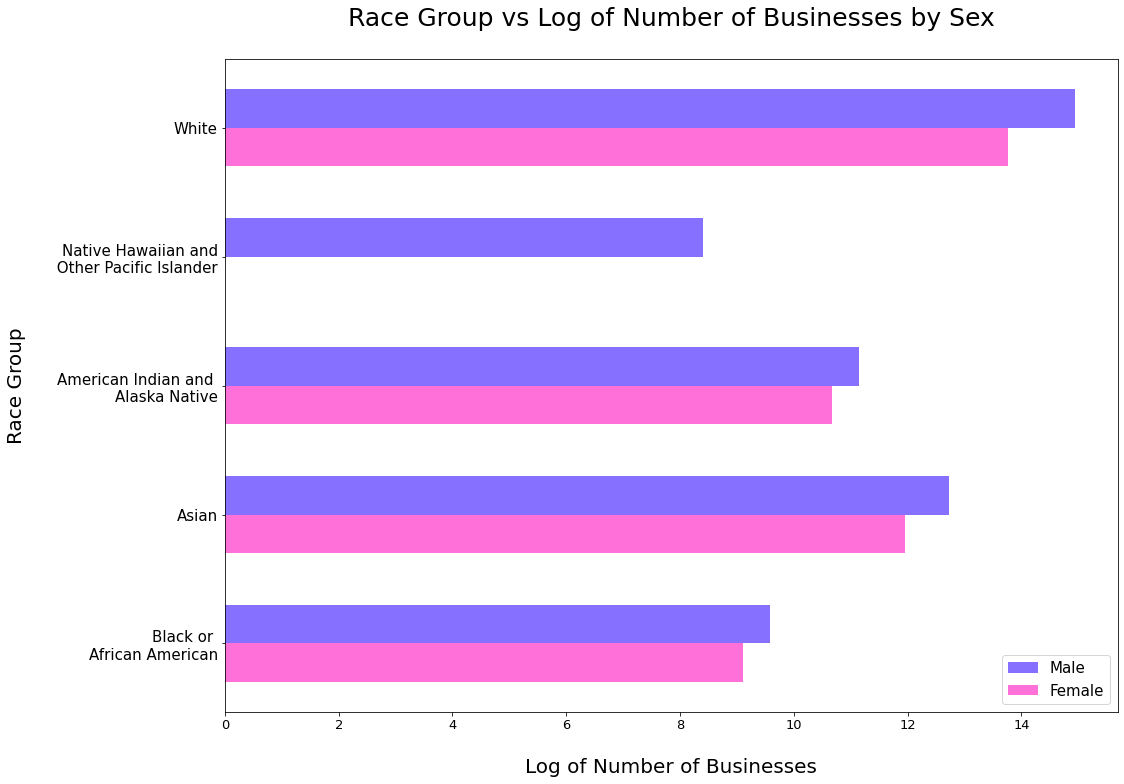

In [23]:
df_company_summary_Overall_male = df_company_summary_Overall[df_company_summary_Overall["SEX_LABEL"] == "Male"].drop("SEX_LABEL", axis=1)
df_company_summary_Overall_female = df_company_summary_Overall[df_company_summary_Overall["SEX_LABEL"] == "Female"].drop("SEX_LABEL", axis=1)
df_company_summary_Overall_male = df_company_summary_Overall_male.groupby("RACE_GROUP_LABEL", as_index=False)["FIRMPDEMP"].sum()
df_company_summary_Overall_female = df_company_summary_Overall_female.groupby("RACE_GROUP_LABEL", as_index=False)["FIRMPDEMP"].sum()
df_company_summary_Overall_male["FIRMPDEMP"] = df_company_summary_Overall_male["FIRMPDEMP"].apply(lambda x: int(x.strip()))
df_company_summary_Overall_female["FIRMPDEMP"] = df_company_summary_Overall_female["FIRMPDEMP"].apply(lambda x: int(x.strip()))
df_company_summary_Overall_male["FIRMPDEMP"] = df_company_summary_Overall_male["FIRMPDEMP"].apply(lambda x: 1 if x == 0 else x)
df_company_summary_Overall_female["FIRMPDEMP"] = df_company_summary_Overall_female["FIRMPDEMP"].apply(lambda x: 1 if x == 0 else x)
df_company_summary_Overall_male["FIRMPDEMP"] = df_company_summary_Overall_male["FIRMPDEMP"].apply(lambda x: math.log(x))
df_company_summary_Overall_female["FIRMPDEMP"] = df_company_summary_Overall_female["FIRMPDEMP"].apply(lambda x: math.log(x))
plt.rcParams["figure.figsize"] = (16,12)
y1 = df_company_summary_Overall_male["FIRMPDEMP"]
y2 = df_company_summary_Overall_female["FIRMPDEMP"]
x = np.arange(5)
labels_list = ['Black or \nAfrican American','Asian','American Indian and \nAlaska Native','Native Hawaiian and\n Other Pacific Islander','White']
width = 0.3
plt.barh(x+.15, y1, width, color='#5133FF', alpha = 0.7)
plt.barh(x-.15, y2, width, color='#FF33CA', alpha= 0.7)
plt.yticks(x, labels_list, fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel("Race Group\n", fontsize = 20)
plt.xlabel("\nLog of Number of Businesses", fontsize = 20)
plt.title("Race Group vs Log of Number of Businesses by Sex\n", fontsize = 25)
plt.legend(["Male","Female"],loc="lower right", fontsize = 15)

plt.show()

This visual shows the Top 5 and Bottom 5 State vs. the Firm Size-to-Population Ratio by Race Groups as seen in the stacked bar graph. We can see that Montana has the highest Firm Size-to-Population Ratio while Louisiana has the smallest. We use a stacked bar graph to see how race demographics transalate relate to the Firm Size-to-Population .

C:\Users\Adam Brewer\AppData\Local\Temp\ipykernel_12436\2252451945.py:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  state_pivot_table["Total"] = state_pivot_table.sum(axis = 1)
C:\Users\Adam Brewer\AppData\Local\Temp\ipykernel_12436\2252451945.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  state_stacked_bar_vals_top_bottom = state_stacked_bar_vals[:5].append(state_stacked_bar_vals[-5:])


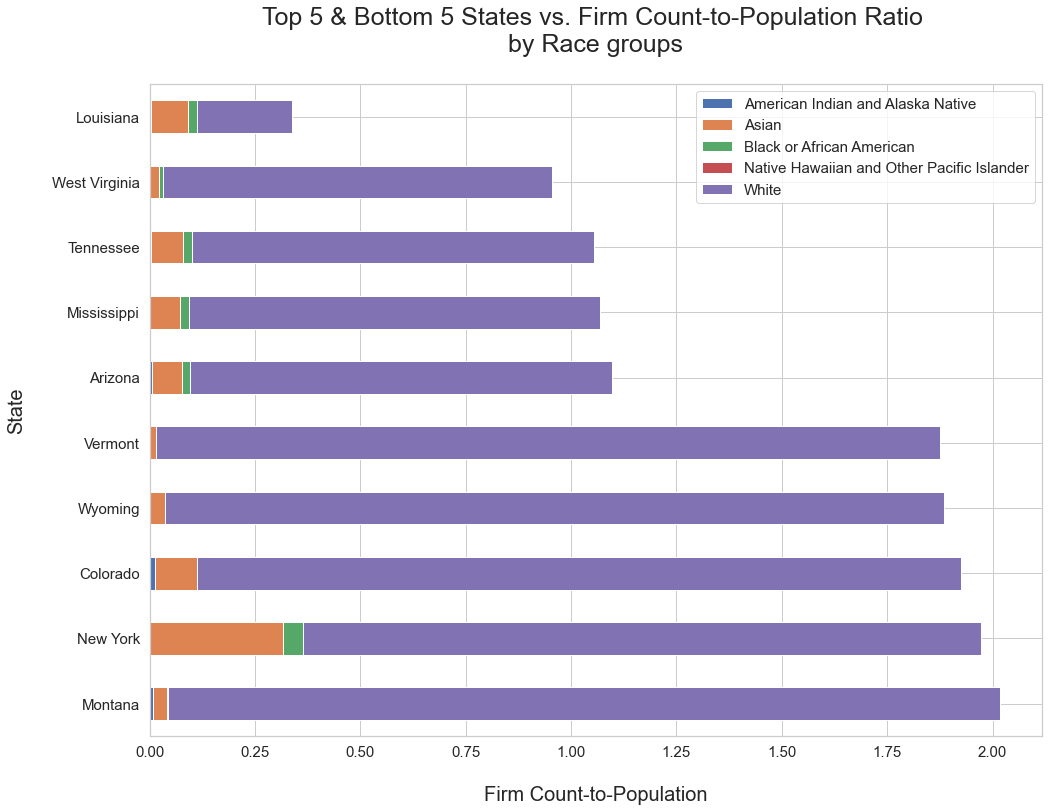

In [24]:
df_company_summary_State_bussniess_per_population_ng = df_company_summary_State_bussniess_per_population.copy().drop("SEX_LABEL", axis=1)
state_pivot_table = pd.pivot_table(df_company_summary_State_bussniess_per_population_ng, index=["State"], columns=["RACE_GROUP_LABEL"], values=["Bus_Num_by_Pop"], aggfunc=sum).fillna(0)
state_pivot_table.columns = ['_'.join(str(s).strip() for s in col if s) for col in state_pivot_table.columns]
state_pivot_table.reset_index(inplace=True)
state_pivot_table = state_pivot_table.rename(columns={'Bus_Num_by_Pop_American Indian and Alaska Native': "American Indian and Alaska Native",
                                   'Bus_Num_by_Pop_Asian': "Asian",
                                   'Bus_Num_by_Pop_Black or African American': "Black or African American",
                                   'Bus_Num_by_Pop_Native Hawaiian and Other Pacific Islander': "Native Hawaiian and Other Pacific Islander",
                                   'Bus_Num_by_Pop_White': "White"})
state_pivot_table["Total"] = state_pivot_table.sum(axis = 1)
state_pivot_table = state_pivot_table.sort_values(by = "Total", ascending=False)
state_stacked_bar_vals = state_pivot_table.drop("Total", axis =1)
state_stacked_bar_vals_top_bottom = state_stacked_bar_vals[:5].append(state_stacked_bar_vals[-5:])
sns.set_theme(style='whitegrid')
state_stacked_bar_vals_top_bottom.set_index('State').plot(kind='barh', stacked=True)
plt.title("Top 5 & Bottom 5 States vs. Firm Count-to-Population Ratio \nby Race groups\n", fontsize = 25)
plt.ylabel("State\n", fontsize=20)
plt.xlabel("\nFirm Count-to-Population", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

This visual zooms in on the top Firm Size-to-Population State which was Montana and shows a Race and Gender breakdown. This visual is interesting because it shows
 the lack of diversity within Montana even though it has the highest Firm Size-to-Population.

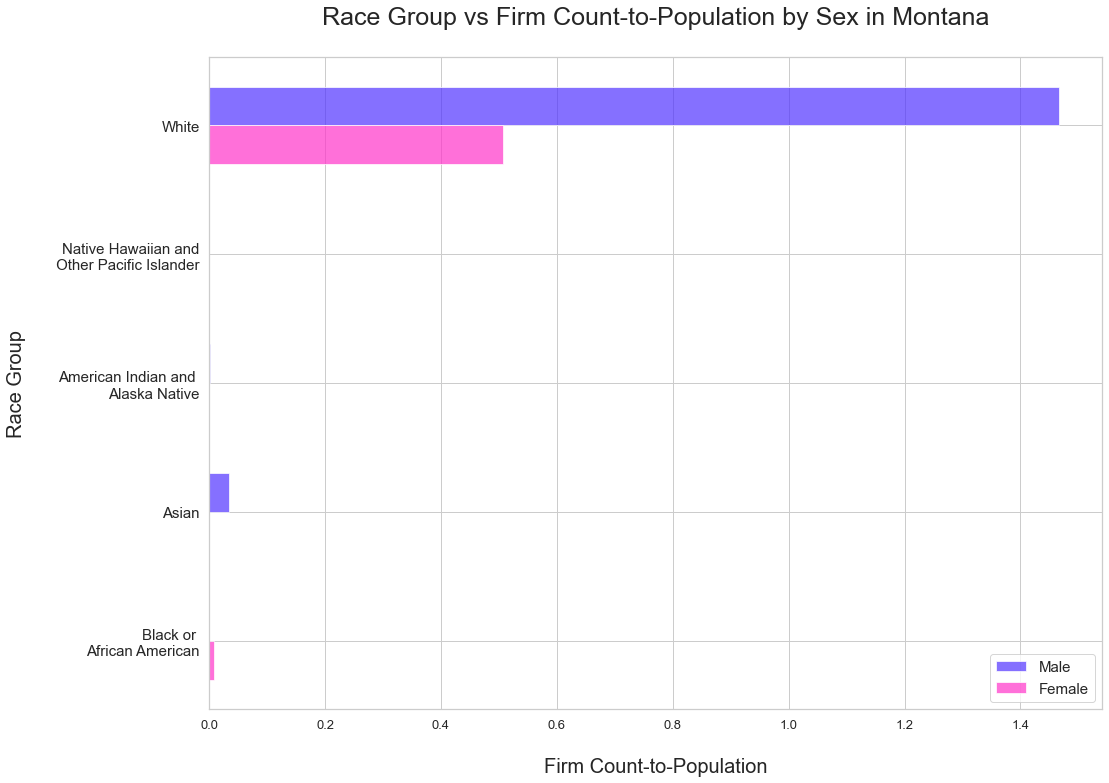

In [25]:
state_stacked_bar_vals_top_1 = df_company_summary_State_bussniess_per_population[df_company_summary_State_bussniess_per_population["State"] == "Montana"]
plt.rcParams["figure.figsize"] = (16,12)
y1 = state_stacked_bar_vals_top_1[state_stacked_bar_vals_top_1["SEX_LABEL"] == "Male"]["Bus_Num_by_Pop"]
y2 = state_stacked_bar_vals_top_1[state_stacked_bar_vals_top_1["SEX_LABEL"] == "Female"]["Bus_Num_by_Pop"]
x = np.arange(5)
labels_list = ['Black or \nAfrican American','Asian','American Indian and \nAlaska Native','Native Hawaiian and\n Other Pacific Islander','White']
width = 0.3
plt.barh(x+.15, y1, width, color='#5133FF', alpha = 0.7)
plt.barh(x-.15, y2, width, color='#FF33CA', alpha= 0.7)
plt.yticks(x, labels_list, fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel("Race Group\n", fontsize = 20)
plt.xlabel("\nFirm Count-to-Population", fontsize = 20)
plt.title("Race Group vs Firm Count-to-Population by Sex in Montana\n", fontsize = 25)
plt.legend(["Male","Female"],loc="lower right", fontsize = 15)
plt.show()

In [26]:
state_stacked_bar_perc_calc = state_pivot_table.copy().sort_values(by = "State", ascending=True)
state_stacked_bar_perc_calc["American Indian and Alaska Native"] = state_stacked_bar_perc_calc["American Indian and Alaska Native"] / state_stacked_bar_perc_calc["Total"]
state_stacked_bar_perc_calc["Asian"] = state_stacked_bar_perc_calc["Asian"] / state_stacked_bar_perc_calc["Total"]
state_stacked_bar_perc_calc["Black or African American"] = state_stacked_bar_perc_calc["Black or African American"] / state_stacked_bar_perc_calc["Total"]
state_stacked_bar_perc_calc["Native Hawaiian and Other Pacific Islander"] = state_stacked_bar_perc_calc["Native Hawaiian and Other Pacific Islander"] / state_stacked_bar_perc_calc["Total"]
state_stacked_bar_perc_calc["White"] = state_stacked_bar_perc_calc["White"] / state_stacked_bar_perc_calc["Total"]
state_stacked_bar_perc_calc = state_stacked_bar_perc_calc.drop("Total", axis =1)
state_stacked_bar_perc_calc["American Indian and Alaska Native"] = state_stacked_bar_perc_calc["American Indian and Alaska Native"].apply(lambda x : x if x <= .25 else -1*(x-.2))
state_stacked_bar_perc_calc["Asian"] = state_stacked_bar_perc_calc["Asian"].apply(lambda x : x if x <= .25 else -1*(x-.2))
state_stacked_bar_perc_calc["Black or African American"] = state_stacked_bar_perc_calc["Black or African American"].apply(lambda x : x if x <= .25 else -1*(x-.2))
state_stacked_bar_perc_calc["Native Hawaiian and Other Pacific Islander"] = state_stacked_bar_perc_calc["Native Hawaiian and Other Pacific Islander"].apply(lambda x : x if x <= .25 else -1*(x-.2))
state_stacked_bar_perc_calc["White"] = state_stacked_bar_perc_calc["White"].apply(lambda x : x if x <= .25 else -1*(x-.2))
state_stacked_bar_perc_calc["Diversity Score"] = state_stacked_bar_perc_calc.sum(axis = 1)
state_stacked_bar_perc_calc = state_stacked_bar_perc_calc.drop(["American Indian and Alaska Native", "Asian", "Black or African American", "Native Hawaiian and Other Pacific Islander", "White"], axis = 1)
state_stacked_bar_perc_calc = state_stacked_bar_perc_calc.sort_values(by ="Diversity Score", ascending=False)

state_stacked_bar_perc = state_pivot_table.copy()
state_stacked_bar_perc["American Indian and Alaska Native"] = (state_stacked_bar_perc["American Indian and Alaska Native"] / state_stacked_bar_perc["Total"]) * 100
state_stacked_bar_perc["Asian"] = (state_stacked_bar_perc["Asian"] / state_stacked_bar_perc["Total"]) * 100
state_stacked_bar_perc["Black or African American"] = (state_stacked_bar_perc["Black or African American"] / state_stacked_bar_perc["Total"]) * 100
state_stacked_bar_perc["Native Hawaiian and Other Pacific Islander"] = (state_stacked_bar_perc["Native Hawaiian and Other Pacific Islander"] / state_stacked_bar_perc["Total"]) * 100
state_stacked_bar_perc["White"] = (state_stacked_bar_perc["White"] / state_stacked_bar_perc["Total"]) * 100
state_stacked_bar_perc = state_stacked_bar_perc.drop("Total", axis =1)
state_stacked_bar_perc = state_stacked_bar_perc.merge(state_stacked_bar_perc_calc, how = 'inner', on = 'State')
state_stacked_bar_perc = state_stacked_bar_perc.sort_values(by="Diversity Score", ascending=False)
state_stacked_bar_perc = state_stacked_bar_perc.drop([16]) # District of Columbia
state_stacked_bar_perc.head()

C:\Users\Adam Brewer\AppData\Local\Temp\ipykernel_12436\1801200888.py:13: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  state_stacked_bar_perc_calc["Diversity Score"] = state_stacked_bar_perc_calc.sum(axis = 1)


,State,American Indian and Alaska Native,Asian,Black or African American,Native Hawaiian and Other Pacific Islander,White,Diversity Score
19,California,0.578376,21.943288,2.045611,0.072170,75.360555,-0.307211
22,Maryland,0.179160,13.264752,6.756054,0.056638,79.743397,-0.394868
1,New York,0.088269,15.985565,2.388982,0.000000,81.537183,-0.430744
26,Georgia,0.163990,12.140719,5.893440,0.052395,81.749456,-0.434989
25,Virginia,0.177107,12.871736,4.259802,0.129263,82.562092,-0.451242


This visual shows the Top 5 and Bottom 5 State vs. the Firm Size-to-Population Ratio by Race Groups ranked by Diversity Score as seen in the percentage based stacked bar graph.

 The Diversity Score is scored based on a state of perfect equillibrum diversity where each race group has exactly 25% of the cummulative Firm Size-to-Population Ratio which is rated as 1 and where no diversity is rated as -0.8 (for example if the entire Firm Size-to-Population ratio is all one race group). The Diversity Score can be found by taking the Firm Size-to-Population ratio divided by the Total Firm Size-to-Population ratio in the State to get a decimal percentage. Then if the decimal diversity score is under or equal to 0.2 (20% of the population), the deciaml diversity score is added to the total diversity score, however, if the decimal diversity score is over 0.25 then we subract 0.2 from the decimal score and multiple that new number by -1 for a weighted decrease of majority race groups. This is then added to the total score so that so that it can subract from the diversity score. This makes it so each race group have equal weighting in the diversity score and lowers the diversity score if any race group is over 25% of the population making less diverse states have a lower diversity score.

 We can see that California has the highest Diversity Score while Maine has the smallest. We use a percentage based stacked bar graph to see how race demographics transalate relate to the Firm Size-to-Population .

C:\Users\Adam Brewer\AppData\Local\Temp\ipykernel_12436\2111465312.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  state_stacked_bar_perc_top_bottom = state_stacked_bar_perc[:5].append(state_stacked_bar_perc[-5:]).drop("Diversity Score", axis = 1)


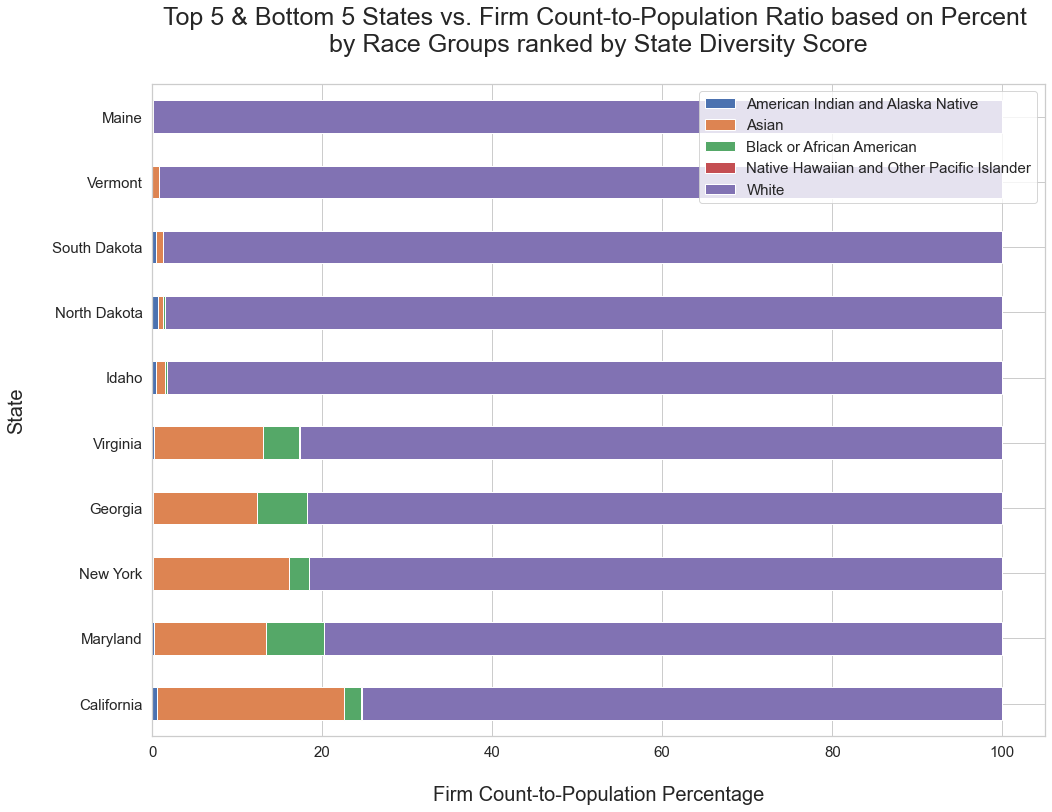

In [27]:
state_stacked_bar_perc_top_bottom = state_stacked_bar_perc[:5].append(state_stacked_bar_perc[-5:]).drop("Diversity Score", axis = 1)
sns.set_theme(style='whitegrid')
state_stacked_bar_perc_top_bottom.set_index('State').plot(kind='barh', stacked=True)
plt.title("Top 5 & Bottom 5 States vs. Firm Count-to-Population Ratio based on Percent \nby Race Groups ranked by State Diversity Score\n", fontsize = 25)
plt.ylabel("State\n", fontsize=20)
plt.xlabel("\nFirm Count-to-Population Percentage", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

This visual zooms in on the top Diversity Score State which was Maryland and shows a Race and Gender breakdown. This visual is interesting because it shows the lack of diversity within California even though it has the highest Diversity Score.

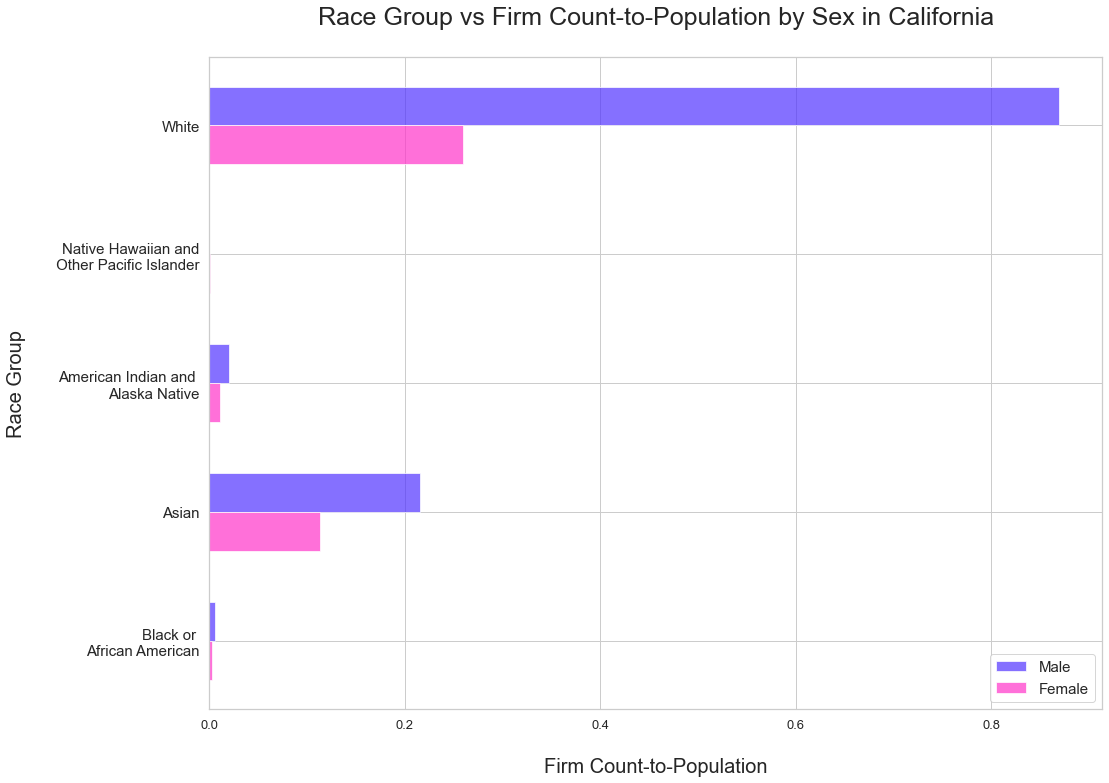

In [28]:
state_stacked_bar_vals_top_1 = df_company_summary_State_bussniess_per_population[df_company_summary_State_bussniess_per_population["State"] == "California"]
plt.rcParams["figure.figsize"] = (16,12)
y1 = state_stacked_bar_vals_top_1[state_stacked_bar_vals_top_1["SEX_LABEL"] == "Male"]["Bus_Num_by_Pop"]
y2 = state_stacked_bar_vals_top_1[state_stacked_bar_vals_top_1["SEX_LABEL"] == "Female"]["Bus_Num_by_Pop"]
x = np.arange(5)
labels_list = ['Black or \nAfrican American','Asian','American Indian and \nAlaska Native','Native Hawaiian and\n Other Pacific Islander','White']
width = 0.3
plt.barh(x+.15, y1, width, color='#5133FF', alpha = 0.7)
plt.barh(x-.15, y2, width, color='#FF33CA', alpha= 0.7)
plt.yticks(x, labels_list, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=15)
plt.ylabel("Race Group\n", fontsize = 20)
plt.xlabel("\nFirm Count-to-Population", fontsize = 20)
plt.title("Race Group vs Firm Count-to-Population by Sex in California\n", fontsize = 25)
plt.legend(["Male","Female"],loc="lower right", fontsize = 15)
plt.show()

### Characteristics of Businesses
***

Correlation matrix between number of employer firms, employees, and annual payroll

In [29]:
df = business[['employees','employer_firms','payroll']]
#high correlation between all of these categories
df.corr()

,employees,employer_firms,payroll
0,,,
employees,1.000000,0.947463,0.989138
employer_firms,0.947463,1.000000,0.919650
payroll,0.989138,0.919650,1.000000


Making functions/setting color palettes for visualizations

In [30]:
def get_min_max(df,column):
    max_min = []
    sorted = df.sort_values(column)
    min = sorted['industry'][0]
    max = sorted['industry'][-1]
    max_min.append(min)
    max_min.append(max)
    return max_min
yellow_patch = mpatches.Patch(color='y', label = 'max/min dispairity')
blue_patch = mpatches.Patch(color='b', label='other')
sns.set_theme(style='whitegrid')

### Sex

When looking purely at the difference between the number of firms owned by men and women, we can see that the largest disparity is in the construction industry with men owning 1,921,683 more firms than women. The smallest numeric disparity is in Utilities, where men only own 6950 more firms than women. However, we can see more true disparity when looking at the number of businesses that men own per a single business that a woman owns.

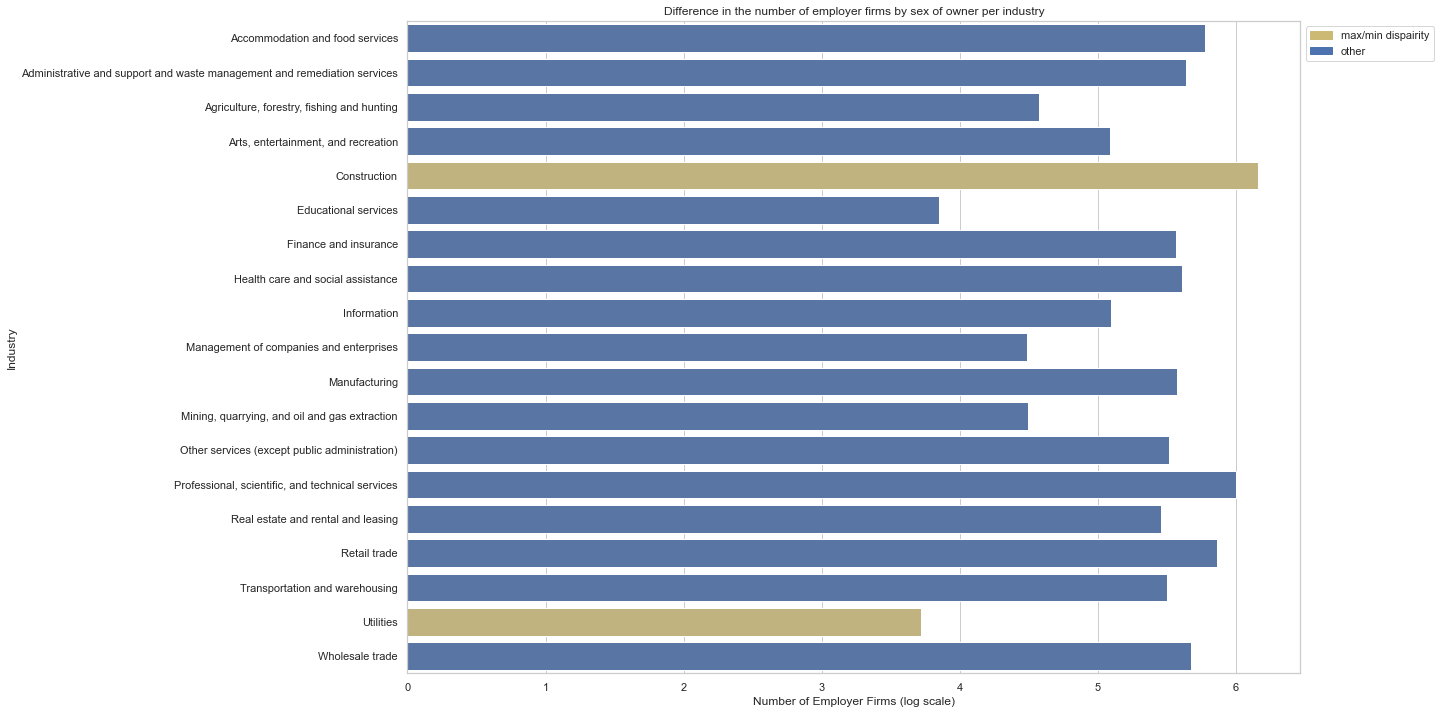

In [31]:
gender_ex = business_gender[(business_gender['industry']!='Industries not classified')&(business_gender['industry']!='Total for all sectors')].copy()
gender_pivot = gender_ex.pivot('industry','sex','employer_firms')
gender_pivot['diff']=gender_pivot['Male']-gender_pivot['Female']
gender_pivot['ratio']=gender_pivot['Male']/gender_pivot['Female']
gender_pivot['log_diff']=gender_pivot['diff'].apply(lambda x: math.log10(x))
gender_pivot['log_ratio']=gender_pivot['ratio'].apply(lambda x: math.log10(x))
gender_pivot['industry']=gender_pivot.index
pal = {industry: 'y' if industry in get_min_max(gender_pivot,'log_diff') else 'b' for industry in gender_pivot.industry.unique()}
ax = sns.barplot(data=gender_pivot,y='industry',x='log_diff',orient='h', palette=pal).set(title='Difference in the number of employer firms by sex of owner per industry', xlabel='Number of Employer Firms (log scale)',ylabel='Industry')
plt.legend(handles=[yellow_patch,blue_patch],loc='best',bbox_to_anchor = (1,1))
plt.show()

Below, we can see that the largest disparity still exists in the Construction insustry, with men owning 8.6 businesses for every 1 business a woman owns. The smallest disparity is in Educational services, with men owning anout 1.1 businesses for every 1 business a woman owns.

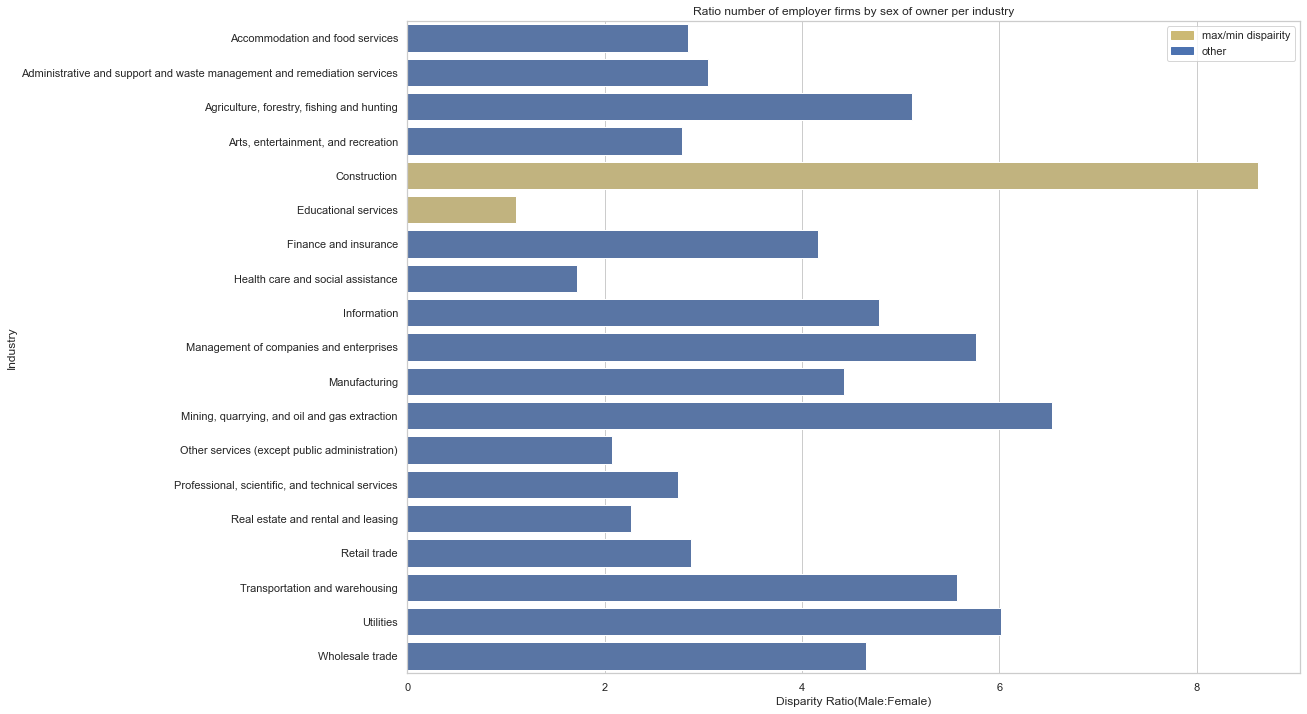

In [33]:
pal = {industry: 'y' if industry in get_min_max(gender_pivot,'ratio') else 'b' for industry in gender_pivot.industry.unique()}
sns.barplot(data=gender_pivot,y='industry',x='ratio',orient='h',palette=pal).set(title='Ratio number of employer firms by sex of owner per industry', xlabel='Disparity Ratio(Male:Female)',ylabel='Industry')
plt.legend(handles=[yellow_patch,blue_patch],loc='best',bbox_to_anchor = (1,1))
plt.show()

### Ethnicity

When looking purely at the difference between the number of firms with non-hispanic and hispanic owners, we can see that the largest disparity is in the Professional, scientific, and technical services industry with non-hispanic business owners owning 2,165,902 more firms than hispanic business owners. The smallest numeric disparity is in Utilities, where non-hispanic business only own 8016 more firms than hispanic business owners. Again, we can see more true disparity when looking at the number of businesses owned by a non-hispanic business owner per a single business owned by a hispanic business owner.

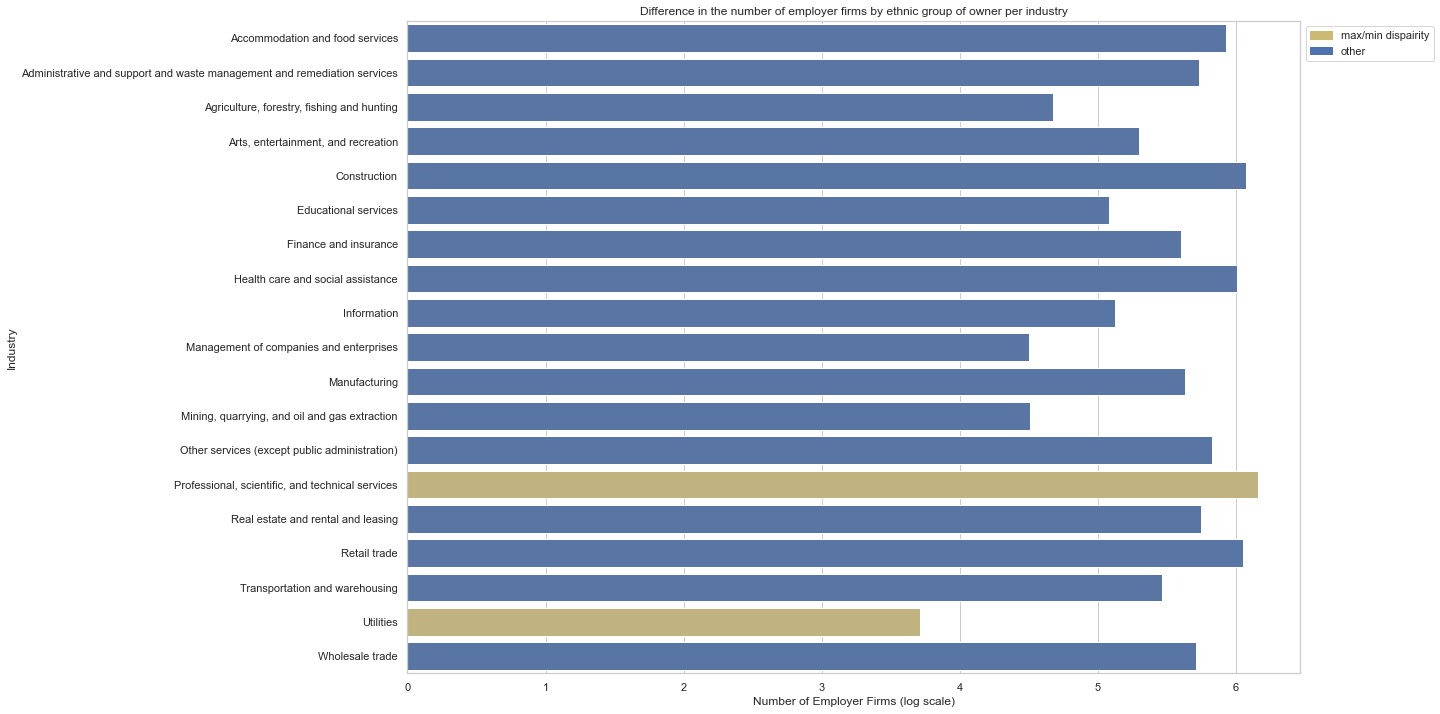

In [316]:
ethnicity_ex = business_ethnicity[(business_ethnicity['industry']!='Industries not classified')&(business_ethnicity['industry']!='Total for all sectors')].copy()
ethnicity_pivot = ethnicity_ex.pivot('industry','ethnic_group','employer_firms')
ethnicity_pivot['diff']=ethnicity_pivot['Non-Hispanic']-ethnicity_pivot['Hispanic']
ethnicity_pivot['ratio']=ethnicity_pivot['Non-Hispanic']/ethnicity_pivot['Hispanic']
ethnicity_pivot['log_diff']=ethnicity_pivot['diff'].apply(lambda x: math.log10(x))
ethnicity_pivot['log_ratio']=ethnicity_pivot['ratio'].apply(lambda x: math.log10(x))
ethnicity_pivot['industry']=ethnicity_pivot.index
pal = {industry: 'y' if industry in get_min_max(ethnicity_pivot,'log_diff') else 'b' for industry in ethnicity_pivot.industry.unique()}
sns.barplot(data=ethnicity_pivot,y='industry',x='log_diff',orient='h',palette=pal).set(title='Difference in the number of employer firms by ethnic group of owner per industry', xlabel='Number of Employer Firms (log scale)',ylabel='Industry')
plt.legend(handles=[yellow_patch,blue_patch],loc='best',bbox_to_anchor = (1,1))
plt.show()

Below, we can see that the largest disparity is actually in in the Agriculture, forestry, fishing and hunting insustry, with non-hispanic business owners owning 269.9 businesses for every 1 business a hispanic business owner owns. The smallest disparity is in Transportation and warehousing, with non-hispanic business owners owning abou 8.6 businesses for every 1 business a hispanic business owner owns.

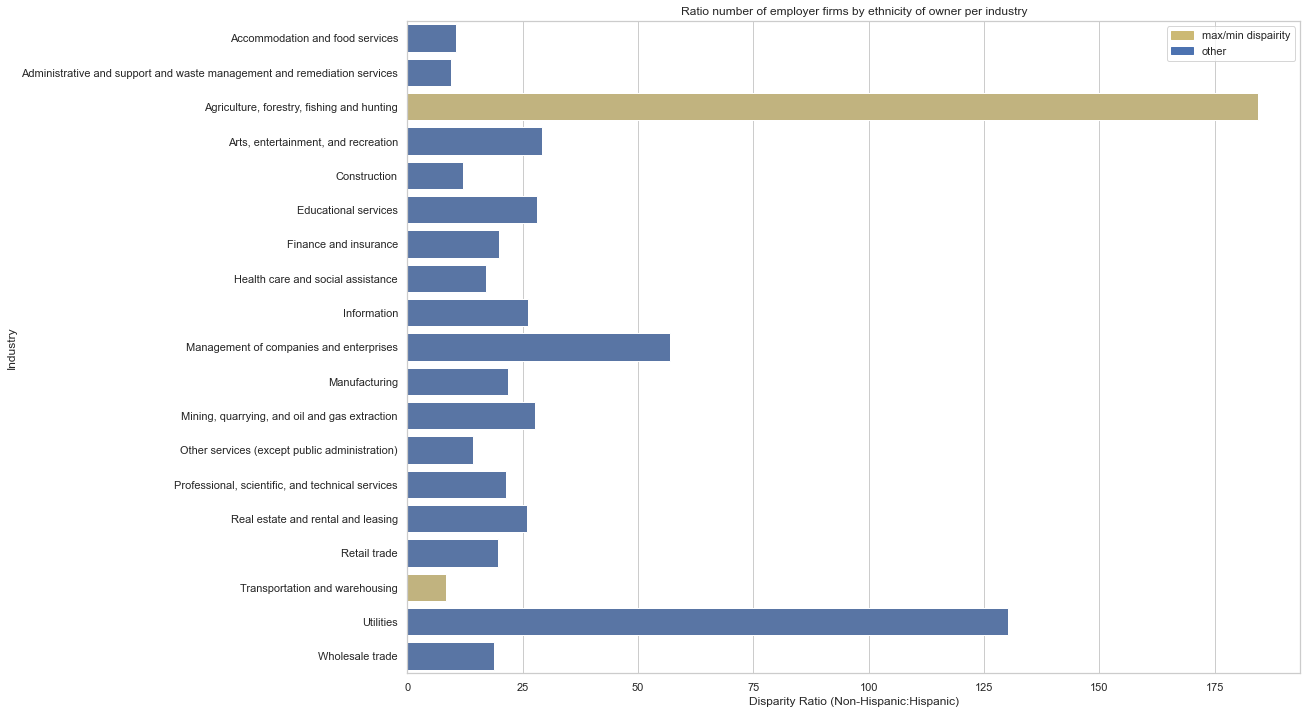

In [317]:
pal = {industry: 'y' if industry in get_min_max(ethnicity_pivot,'ratio') else 'b' for industry in ethnicity_pivot.industry.unique()}
sns.barplot(data=ethnicity_pivot,y='industry',x='ratio',orient='h',palette=pal).set(title='Ratio number of employer firms by ethnicity of owner per industry', xlabel='Disparity Ratio (Non-Hispanic:Hispanic)',ylabel='Industry')
plt.legend(handles=[yellow_patch,blue_patch],loc='best',bbox_to_anchor = (1,1))
plt.show()

### Race
When looking purely at the difference between the number of firms with non-minority and minority owners, we can see that the largest disparity is in the Professional, scientific, and technical services industry with non-minority business owners owning 1,661,851 more firms than minority business owners. The smallest numeric disparity is in Utilities, where non-minority business only own 7335 more firms than minority business owners. Again, we can see more true disparity when looking at the number of businesses owned by a non-minority business owner per a single business owned by a minority business owner.

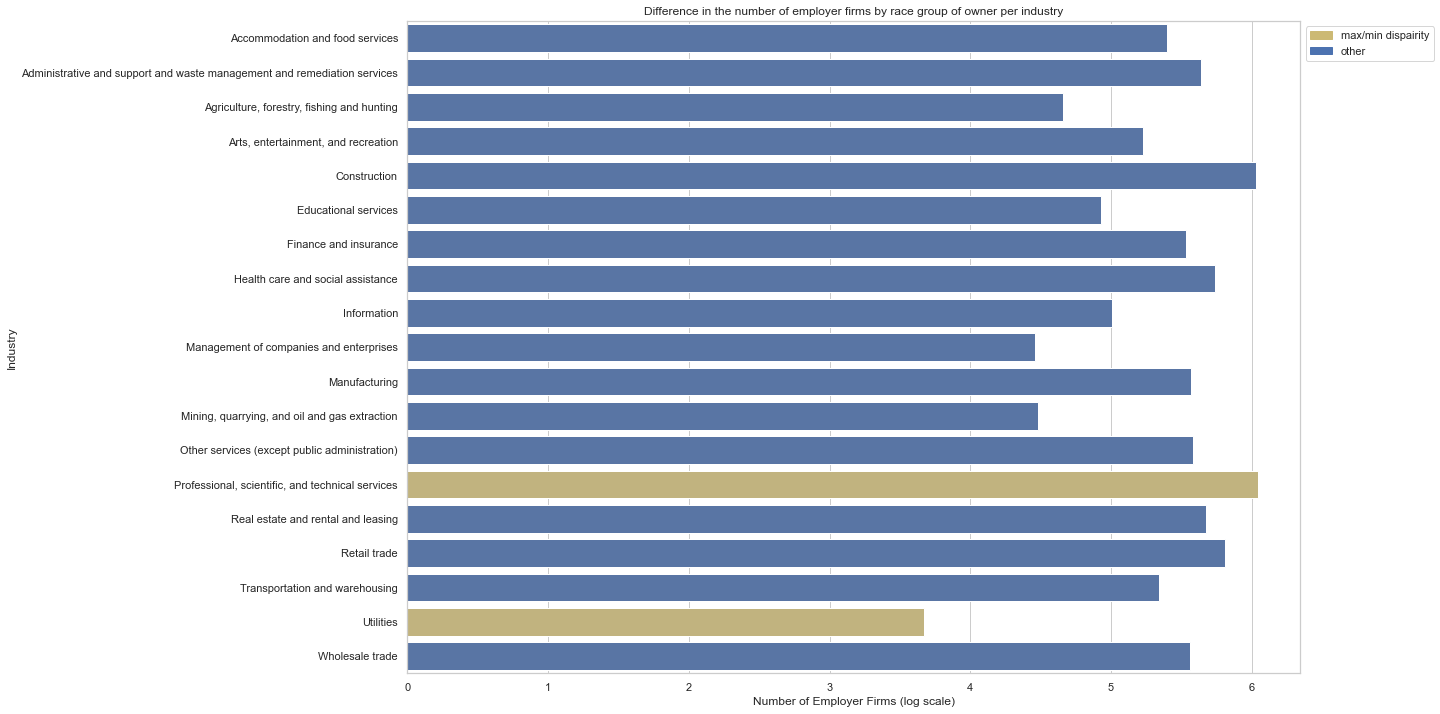

In [318]:
race_ex = business_race[(business_race['industry']!='Industries not classified')&(business_race['industry']!='Total for all sectors')].copy()
race_pivot =race_ex.pivot('industry','race','employer_firms')
race_pivot['diff']=race_pivot['Nonminority']-race_pivot['Minority']
race_pivot['ratio']=race_pivot['Nonminority']/race_pivot['Minority']
race_pivot['industry']=race_pivot.index
race_pivot['log_diff']=race_pivot['diff'].apply(lambda x: math.log10(x))
race_pivot['log_ratio']=race_pivot['ratio'].apply(lambda x: math.log10(x))
pal = {industry: 'y' if industry in get_min_max(race_pivot,'log_diff') else 'b' for industry in race_pivot.industry.unique()}
sns.barplot(data=race_pivot,y='industry',x='log_diff',orient='h',palette=pal).set(title='Difference in the number of employer firms by race group of owner per industry', xlabel='Number of Employer Firms (log scale)',ylabel='Industry')
plt.legend(handles=[yellow_patch,blue_patch],loc='best',bbox_to_anchor = (1,1))
plt.show()

Below, we can see that the largest disparity is actually in in the Agriculture, forestry, fishing and hunting insustry, with non-minority business owners owning 166.1 businesses for every 1 business a minority business owner owns. The smallest disparity is in 3	Accommodation and food services, with non-minority business owners owning 1.6 businesses for every 1 business a minority business owner owns.

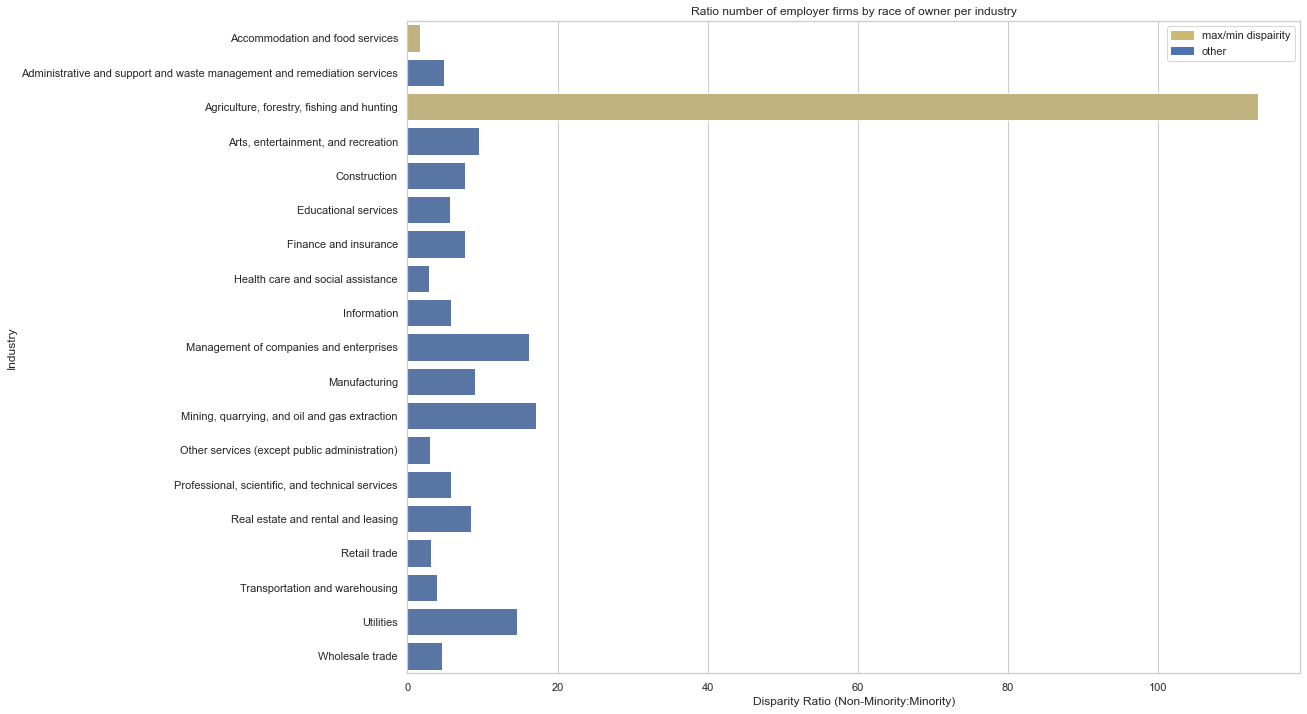

In [319]:
pal = {industry: 'y' if industry in get_min_max(race_pivot,'ratio') else 'b' for industry in race_pivot.industry.unique()}
sns.barplot(data=race_pivot,y='industry',x='ratio',orient='h',palette=pal).set(title='Ratio number of employer firms by race of owner per industry', xlabel='Disparity Ratio (Non-Minority:Minority)',ylabel='Industry')
plt.legend(handles=[yellow_patch,blue_patch],loc='best',bbox_to_anchor = (1,1))
plt.show()

Below, we show a comparison of the disparity ratios among the 3 demographic groups (sex, ethnicity, and race). Note that the hightest disparity ratio is in the ethnicity group, with a median ratio of about 21.3 (1.3 on a log scale) businesses with non-hispanic owners per every 1 business with a hispanic owner. The median disparity ratios for sex and race are about 4.2 (0.6 on a log scale) and 5.8 (0.76 on a log scale) respectively.

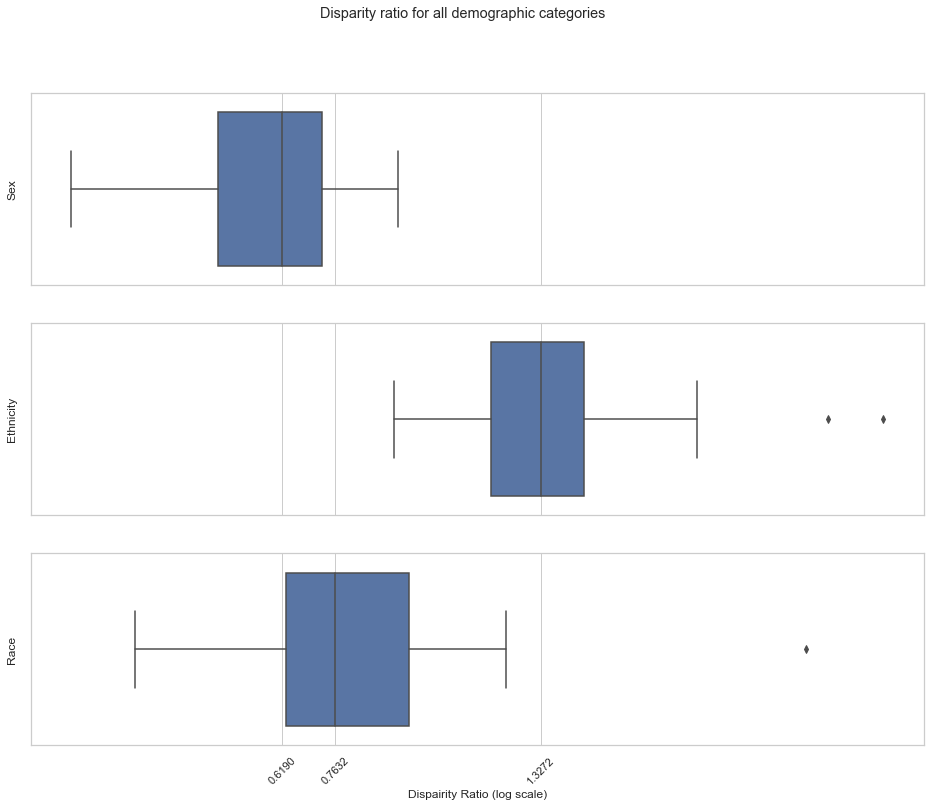

In [320]:
f, axes = plt.subplots(nrows = 3,ncols = 1,sharex=True)
f.suptitle('Disparity ratio for all demographic categories')
sns.boxplot(data=gender_pivot, x='log_ratio',ax=axes[0]).set(xlabel = '',ylabel= 'Sex')
sns.boxplot(data=ethnicity_pivot, x='log_ratio',ax=axes[1]).set(xlabel = '',ylabel= 'Ethnicity')
sns.boxplot(data=race_pivot, x='log_ratio',ax=axes[2]).set(xlabel = 'Dispairity Ratio (log scale)',ylabel= 'Race')
plt.xticks([gender_pivot.log_ratio.median(),race_pivot.log_ratio.median(),ethnicity_pivot.log_ratio.median()],rotation=45)
plt.show()

### Characteristics of Bussniess Owners
***

<AxesSubplot:title={'center':'Business Owners by Sex'}, ylabel='numOwners'>

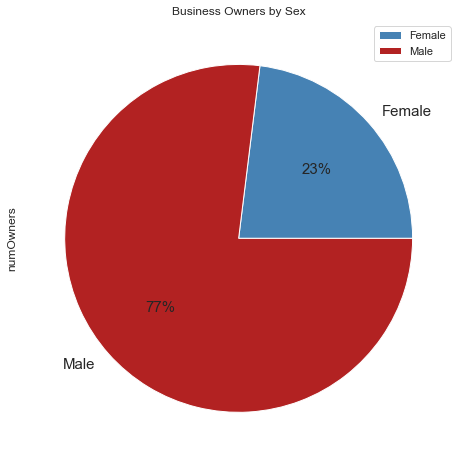

In [321]:
businessOwnerSex = businessOwner.drop(['raceLabel'], axis=1)
businessOwnerSex.groupby(['sexLabel']).sum().plot(title="Business Owners by Sex", fontsize =15,figsize=(8,8), kind='pie', y='numOwners', autopct='%1.0f%%', labels=['Female', 'Male'], colors =['steelblue', 'firebrick'])

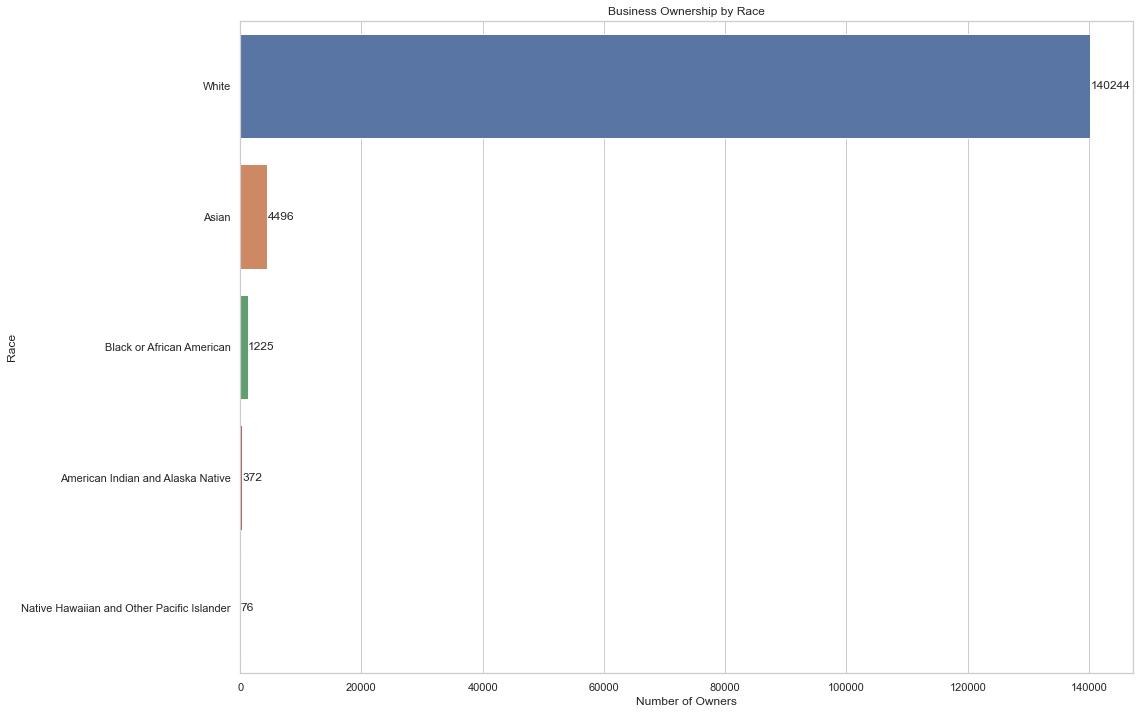

In [322]:
businessOwnerRace = businessOwner.drop(['sexLabel'], axis=1)
businessOwnerRace = businessOwnerRace[businessOwner.raceLabel.isin(['Minority', 'Nonminority']) == False]
businessOwnerRace = businessOwnerRace .groupby(['raceLabel'], as_index=False).sum()
businessOwnerRace = businessOwnerRace.sort_values('numOwners', ascending = False)
ax = sns.barplot(x='numOwners', y='raceLabel', data = businessOwnerRace)
ax.set_xlabel('Number of Owners')
ax.set_ylabel('Race')
ax.set_title('Business Ownership by Race')
ax.bar_label(ax.containers[0])
plt.show()

In [323]:
fig = px.choropleth(locations=businessOwnerState['stateCode'], color = businessOwnerState['ownerPer100People'], locationmode="USA-states", scope="usa", title ="Business Owner Respondants Per 100 People by U.S State", color_continuous_scale="reds")
fig.layout.coloraxis.colorbar.title = 'Rate of Business Ownership'
fig.show()

### Technology Characteristicsof Businesses
***

There are so many directions I could've gone in with analyzing the technology data. I could've looked at which tech was least used or which tech was in total use. I didn't just want to go off of the largest population of 2018 or the largest firm size in 2018, becuase it would always be CA. Trying to look at all states together is quite overwhelming too. I can see what tech is in high usage but there's just too much going on and I don't know what direction to go in.

Text(0.5, 1.0, 'Number of Firms Reporting their High Usage Technology per State')

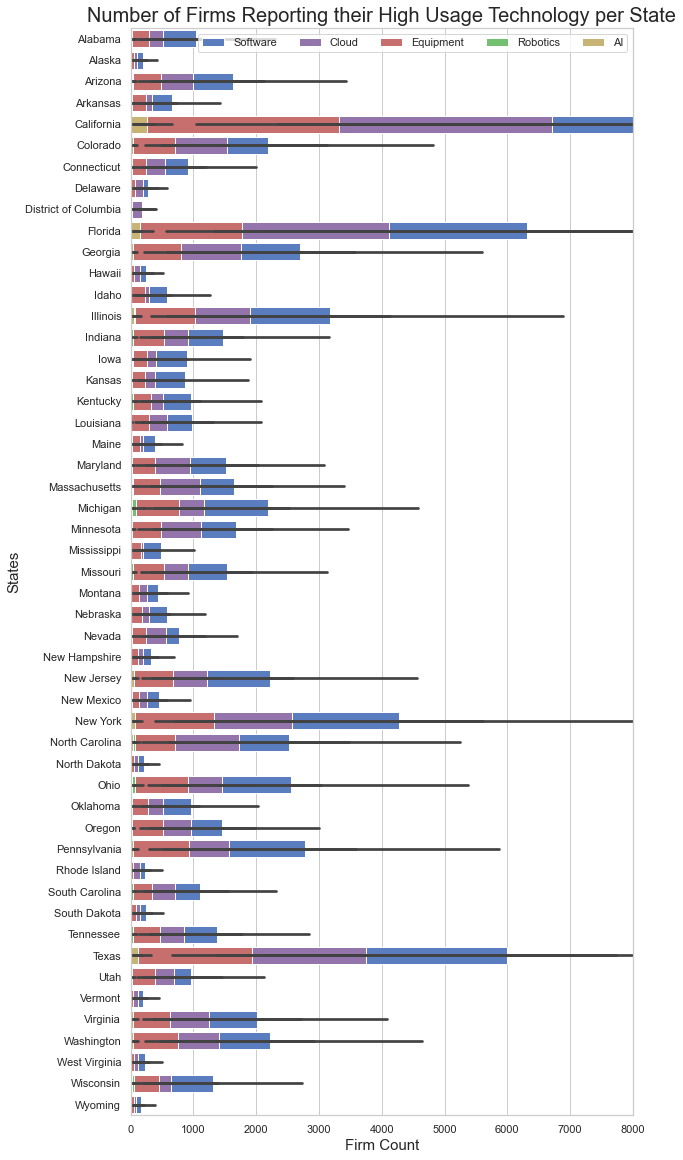

In [324]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (9,20))
AIHigh = tech_summary_state.loc[tech_summary_state['TECHUSE'] == 'T1E03B05'].sort_values(by = 'State')
CloudHigh  = tech_summary_state.loc[tech_summary_state['TECHUSE'] == 'T2E03B05'].sort_values(by = 'State')
RoboticsHigh  = tech_summary_state.loc[tech_summary_state['TECHUSE'] == 'T4E03B05'].sort_values(by = 'State')
SoftwareHigh  = tech_summary_state.loc[tech_summary_state['TECHUSE'] == 'T3E03B05'].sort_values(by = 'State')
EquipmentHigh  = tech_summary_state.loc[tech_summary_state['TECHUSE'] == 'T5E03B05'].sort_values(by = 'State')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "State", data = SoftwareHigh, color = 'b', label = 'Software')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y ="State", data = CloudHigh, color = 'm', label = 'Cloud')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "State", data = EquipmentHigh, color = 'r', label ='Equipment')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "State", data = RoboticsHigh, color = 'g', label = 'Robotics')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "State", data = AIHigh, color = 'y', label = 'AI')
ax.legend(ncol=5, loc ='upper right', frameon=True)
ax.set_xlim(0,8000)
ax.set_ylabel("States", size = 15) 
ax.set_xlabel('Firm Count', size = 15)
ax.set_title('Number of Firms Reporting their High Usage Technology per State', size = 20)

I decided to format my scope to continuously zoom in on the top. So first, I wanted to see which state had the highest # of firm to population ratio in the reporting. We wanted to see which reports were the best representation of the state.

In [325]:
#Code TxE03BA9 is the total reporting for that tech type. Does not break down into high or low use, just shows the total
total_AI_reporting = tech_summary_state.loc[tech_summary_state['TECHUSE'] == 'T1E03BA9'].sort_values(by = 'FIRMTOPOP', ascending = False)
total_cloud_reporting = tech_summary_state.loc[tech_summary_state['TECHUSE'] == 'T2E03BA9'].sort_values(by = 'FIRMTOPOP', ascending = False)
total_software_reporting = tech_summary_state.loc[tech_summary_state['TECHUSE'] == 'T3E03BA9'].sort_values(by = 'FIRMTOPOP', ascending = False)
total_robotics_reporting = tech_summary_state.loc[tech_summary_state['TECHUSE'] == 'T4E03BA9'].sort_values(by = 'FIRMTOPOP', ascending = False)
total_equipment_reporting = tech_summary_state.loc[tech_summary_state['TECHUSE'] == 'T5E03BA9'].sort_values(by = 'FIRMTOPOP', ascending = False)


Even tho Cali has the largest pop and largest # of firms in the report, Montana's # of firm reporting better represents Montana's population. Now let's take a closer look into Montana. What tech are the business of Montana using? It's important to note how this report was made/how the survey was taken. Q: During the three years 2016 to 2018, to what extent did this business use the following technologies inproduction processes for goods or services?” The survey then is broken down further into counting the # of firms that reported the level of tech tech use. Ex: how many firms reported moderate use for cloud, no use for robotics, high use for software etc. I'm focusing on the tech that was reported in high use. Explain that the columns are LAYERED not stacked. 

Text(0.5, 1.0, 'States with Highest Firm Count-to-Population Ratio ')

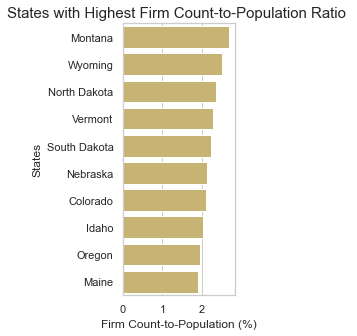

In [326]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (2,5))
sns.set_color_codes("muted")
sns.barplot(x="FIRMTOPOP", y ="State", data = total_software_reporting.head(10),  color = 'b', label = 'Software')
sns.set_color_codes("muted")
sns.barplot(x="FIRMTOPOP", y = "State", data = total_cloud_reporting.head(10), color = 'm', label = 'Cloud')
sns.set_color_codes("muted")
sns.barplot(x="FIRMTOPOP", y = "State", data = total_equipment_reporting.head(10), color = 'r', label = 'Equipment')
sns.set_color_codes("muted")
sns.barplot(x="FIRMTOPOP", y = "State", data = total_robotics_reporting.head(10), color = 'g', label = 'Robotics')
sns.set_color_codes("muted")
sns.barplot(x="FIRMTOPOP", y = "State", data = total_AI_reporting.head(10), color = 'y', label = 'AI')
ax.set_ylabel("States", size = 12) 
ax.set_xlabel('Firm Count-to-Population (%)', size = 12)
ax.set_title('States with Highest Firm Count-to-Population Ratio ', size = 15)

In [327]:
total_Montana_reporting = tech_summary_state.loc[tech_summary_state['State'] == 'Montana'].sort_values(by = 'FIRMTOPOP', ascending = False)
Montana_high_AI = total_Montana_reporting.loc[total_Montana_reporting['TECHUSE'] == 'T1E03B05'].sort_values(by = 'FIRMTOPOP', ascending = False)
Montana_high_cloud = total_Montana_reporting.loc[total_Montana_reporting['TECHUSE'] == 'T2E03B05'].sort_values(by = 'FIRMTOPOP', ascending = False)
Montana_high_software = total_Montana_reporting.loc[total_Montana_reporting['TECHUSE'] == 'T3E03B05'].sort_values(by = 'FIRMTOPOP', ascending = False)
Montana_high_robotics = total_Montana_reporting.loc[total_Montana_reporting['TECHUSE'] == 'T4E03B05'].sort_values(by = 'FIRMTOPOP', ascending = False)
Montana_high_equipment = total_Montana_reporting.loc[total_Montana_reporting['TECHUSE'] == 'T5E03B05'].sort_values(by = 'FIRMTOPOP', ascending = False)

Text(0.5, 1.0, "Montana's Highest Used Technology")

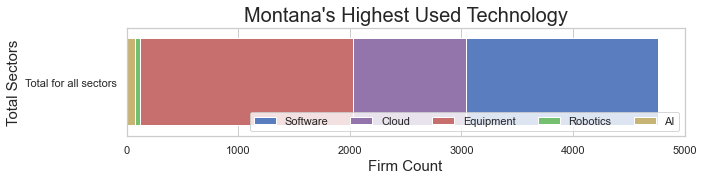

In [328]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (10,2))
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y ="NAICS2017_LABEL", data = Montana_high_software[:1],  color = 'b', label = 'Software')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "NAICS2017_LABEL", data = Montana_high_cloud[:1], color = 'm', label = 'Cloud')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "NAICS2017_LABEL", data = Montana_high_equipment[:1], color = 'r', label = 'Equipment')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "NAICS2017_LABEL", data = Montana_high_robotics[:1], color = 'g', label = 'Robotics')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "NAICS2017_LABEL", data = Montana_high_AI[:1], color = 'y', label = 'AI')
ax.legend(ncol=5, loc ='lower right', frameon=True)
ax.set_xlim(0,5000)
ax.set_ylabel("Total Sectors", size = 15) 
ax.set_xlabel('Firm Count', size = 15)
ax.set_title('Montana\'s Highest Used Technology', size = 20)

Specialized software is the highest used and most used tech in Montana across all industries. What industries use this? What industry uses it the most? Is specialized software the top choice among most industries?

Text(0.5, 1.0, "Montana's Industries and their High Usage Technology")

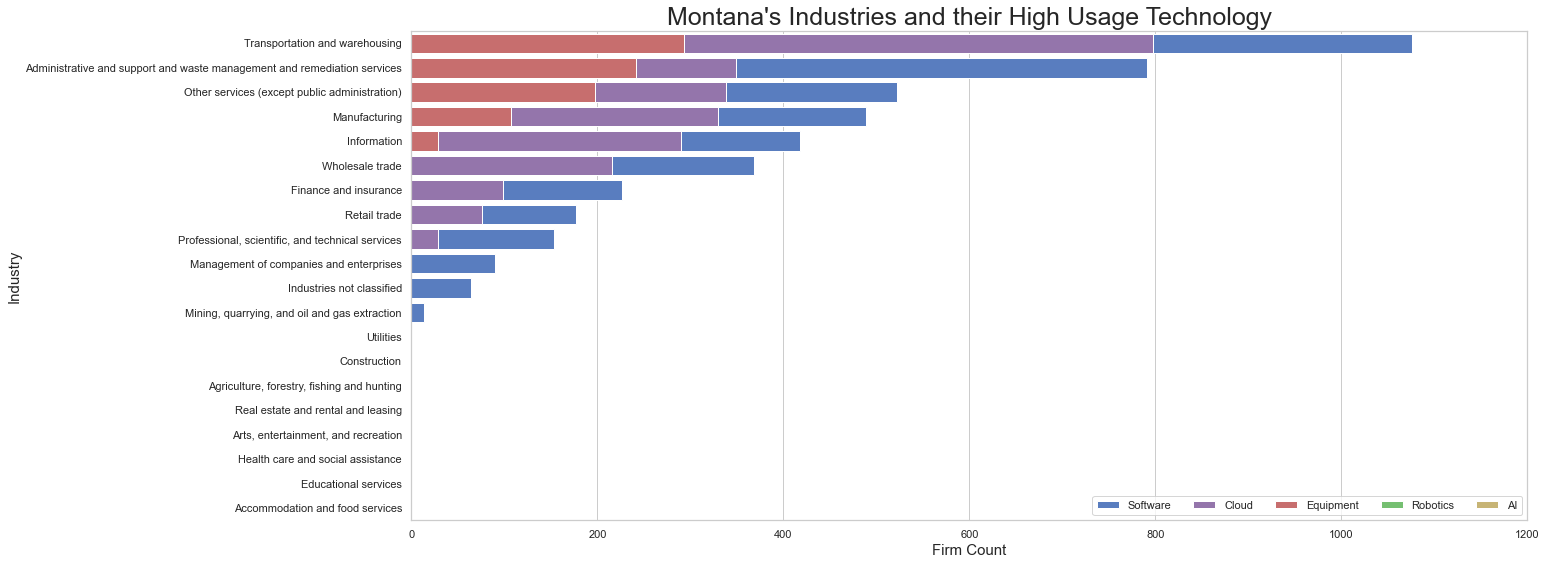

In [329]:
sns.set_theme(style = "whitegrid")
f, ax = plt.subplots(figsize = (20,9))
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y ="NAICS2017_LABEL", data = Montana_high_software[1:],  color = 'b', label = 'Software')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "NAICS2017_LABEL", data = Montana_high_cloud[1:], color = 'm', label = 'Cloud')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "NAICS2017_LABEL", data = Montana_high_equipment[1:], color = 'r', label = 'Equipment')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "NAICS2017_LABEL", data = Montana_high_robotics[1:], color = 'g', label = 'Robotics')
sns.set_color_codes("muted")
sns.barplot(x="FIRMPDEMP", y = "NAICS2017_LABEL", data = Montana_high_AI[1:], color = 'y', label = 'AI')
ax.legend(ncol=5, loc ='lower right', frameon=True)
ax.set_xlim(0,1200)
ax.set_ylabel("Industry", size = 15) 
ax.set_xlabel('Firm Count', size = 15)
ax.set_title('Montana\'s Industries and their High Usage Technology', size = 25)

Transportation and warehousing seems to be the industry that uses specialized software the most. But it could also be that most of the survey entries just happen to come from that industry so gotta keep that in mind. It's great to see that the high used tech is consistent across industries, Software, then cloud, then equipment. The census data does not break down individual states by breakdown categories like gender or race but if they did, I'd love to zoom in a step further to truly see what the individual is using.